<a href="https://colab.research.google.com/github/mkane968/Text-Mining-with-Student-Papers/blob/main/Text_Mining_Student_Papers_12_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Text Mining Student Papers
## Introduction
How should students' learning be measured in first-year writing courses? SOME LINK. In the Fall 2022 Cultural Analytics practicum, I investigated the value of text mining to first-year writing program assessment. This project was developed in the context of Temple University's First-Year Writing Program, with attention to the specific writing outcomes they expect students to attain upon successfully completing first-year writing courses. Given the current constraints of my corpus (a pilot sample, not wholly representative of the data I plan to collect for my full dissertation study), I focused on two broad outcomes:

1.   Use rhetorical terminology and principles to analyze how a source makes an argument
2.   Identify and engage with arguments made in secondary sources

The Python code I've developed over the course of this semester demonstrates two main ways that text-mining can support program assessment. First, provides a reliable and efficient method of identifying key passages in a corpora of student work where each outcome is operationalized, based on terminology and practices valuable to the researcher/instructor. Further, text-mining illuminates distinct ways students use language when operationalizing different writing outcomes (rhetorical analysis, source engagement) and with different levels of success (as correlated to grades). 

In the remainder of this blog post, I'll discuss sections of the pipeline I've developed in Google Colab and how the work holds value for writing program instructors and administrators.



## 1. Install Packages

In [1]:
#Mount Google Drive
from google.colab import drive
from google.colab import files

#Install glob
import glob 

#Install pandas
import pandas as pd

#Install numpy
import numpy as np

#Imports the Natural Language Toolkit, which is necessary to install NLTK packages and libraries
#!pip install nltk
import nltk

#Installs libraries and packages to tokenize text
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from  nltk.text import ConcordanceIndex

#Installs libraries and packages to clean text
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

#Import matplotlib for visualizations
import matplotlib.pyplot as plt


#Imports spaCy itself, necessary to use features 
#!pip install spaCy
import spacy
#Load the natural language processing pipeline
nlp = spacy.load("en_core_web_sm")
#Load spaCy visualizer
from spacy import displacy

from scipy import stats

import re  # For preprocessing
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import logging  # Setting up the loggings to monitor gensim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2. Import Student Essays and Metadata

###Import Student Essays and Add to DataFrame

In [2]:
#Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Add files to upload from local machine
uploaded = files.upload()

Saving achesonalessandro_193606_13858036_Final Portfolio Eng 802 - Acheson .txt to achesonalessandro_193606_13858036_Final Portfolio Eng 802 - Acheson .txt
Saving ahenkoraravenmanu_LATE_232002_18873129_English 0802 Portfolio - Raven Ahenkora.txt to ahenkoraravenmanu_LATE_232002_18873129_English 0802 Portfolio - Raven Ahenkora.txt
Saving alleyneimanicarmen_191168_13829820_English Portfolio-Final..txt to alleyneimanicarmen_191168_13829820_English Portfolio-Final..txt
Saving arenamichael_181150_13850639_Final Portfolio.txt to arenamichael_181150_13850639_Final Portfolio.txt
Saving bedellolivia_195145_16640649_Analytical Reading and Writing Final Portfolio.txt to bedellolivia_195145_16640649_Analytical Reading and Writing Final Portfolio.txt
Saving benjamincamillia_193400_11506010_Camillia Benjamin Final Portfolio.txt to benjamincamillia_193400_11506010_Camillia Benjamin Final Portfolio.txt
Saving bernsteingage_LATE_227638_18903293_Final Portfolio- English 0802.txt to bernsteingage_LATE_22

In [4]:
#Put essays into dataframe
essays = pd.DataFrame.from_dict(uploaded, orient='index')

#Reset index and add column names to make wrangling easier
essays = essays.reset_index()
essays.columns = ["ID", "Text"]

#Remove encoding characters from Text column (b'\xef\xbb\xbf)
essays['Text'] = essays['Text'].apply(lambda x: x.decode('utf-8'))

#Remove newline characters and put in new column 
essays['Text_Newlines'] = essays['Text']
essays['Text'] = essays['Text'].str.replace(r'\s+|\\r', ' ', regex=True) 
essays['Text'] = essays['Text'].str.replace(r'\s+|\\n', ' ', regex=True) 
essays.head()

,ID,Text,Text_Newlines
0,achesonalessandro_193606_13858036_Final Portfo...,"I have learned a lot through English 802, mor...","\tI have learned a lot through English 802, mo..."
1,ahenkoraravenmanu_LATE_232002_18873129_English...,Raven Ahenkora Professor Megan Kane English 08...,Raven Ahenkora\nProfessor Megan Kane\nEnglish ...
2,alleyneimanicarmen_191168_13829820_English Por...,Imani Alleyne SaraGrace H Stefan English 802 5...,Imani Alleyne\n\nSaraGrace H Stefan\n\nEnglish...
3,arenamichael_181150_13850639_Final Portfolio.txt,"Michael Arena Professor stefan English 0802, S...",Michael Arena \nProfessor stefan\nEnglish 0802...
4,bedellolivia_195145_16640649_Analytical Readin...,Olivia Bedell Professor Megan Kane ENG 802 14 ...,Olivia Bedell\nProfessor Megan Kane\nENG 802\n...


### Add column without identifying information from each paper ID (instructor/student names) 

In [7]:
#Remove identifying information from ID
#Remove any occurences of "LATE_" from dataset (otherwise will skew ID cleaning)
essays['ID'] = essays['ID'].str.replace(r'LATE_', '', regex=True) 

#Split book on first underscore (_) in ID, keep only text in between first and second underscore (ID number)
start = essays["ID"].str.split("_", expand = True)
essays['ID'] = start[1]
essays['ID'] = essays['ID'].astype(int)
essays

AttributeError: ignored

In [6]:
len(essays)

147

### Import grades and additional metadata to second dataframe


In [6]:
#Upload csvs with essay metadata
uploaded_grades = files.upload()

Saving 2022-09-13T0943_Grades-LA-ENG-0802-711-10742-202220.csv to 2022-09-13T0943_Grades-LA-ENG-0802-711-10742-202220.csv
Saving 2022-09-13T0945_Grades-LA-ENG-0802-062-37264-202203.csv to 2022-09-13T0945_Grades-LA-ENG-0802-062-37264-202203.csv
Saving 2022-11-28T1326_Grades-LA-ENG-0802-011-4684-202103.csv to 2022-11-28T1326_Grades-LA-ENG-0802-011-4684-202103.csv
Saving 2022-11-28T1331_Grades-LA-ENG-0802-012-3352-202136.csv to 2022-11-28T1331_Grades-LA-ENG-0802-012-3352-202136.csv
Saving 2022-11-28T1332_Grades-LA-ENG-0802-010-3350-202036.csv to 2022-11-28T1332_Grades-LA-ENG-0802-010-3350-202036.csv
Saving 2022-12-03T2145_Grades-LA-ENG-0802-039-3375-202036.csv to 2022-12-03T2145_Grades-LA-ENG-0802-039-3375-202036.csv
Saving 2022-12-03T2146_Grades-LA-ENG-0802-010-4683-202103.csv to 2022-12-03T2146_Grades-LA-ENG-0802-010-4683-202103.csv


In [8]:
#Link to path where csv files are stored in drive
local_path = r'/content'

#Create variable to store all csvs in path
filenames = glob.glob(local_path + "/*.csv")

#Create df list for all csvs
dfs = [pd.read_csv(filename) for filename in filenames]

len(filenames)

7

In [9]:
# Concatenate all data into one DataFrame
metadata = pd.concat(dfs, ignore_index=True)

#Change data to string (for further cleaning)
metadata.astype(str)

metadata.head()

,Student,ID,SIS Login ID,Section,Submit Complete Portfolio Here (Due December 7th) (1014919),Assignments Current Points,Assignments Final Points,Assignments Current Score,Assignments Unposted Current Score,Assignments Final Score,...,Final Portfolio (878160),Final Portfolio (1676963),Attendance and Weekly Assignments Current Score,Attendance and Weekly Assignments Unposted Current Score,Attendance and Weekly Assignments Final Score,Attendance and Weekly Assignments Unposted Final Score,Portfolio Preparation Current Score,Portfolio Preparation Unposted Current Score,Portfolio Preparation Final Score,Portfolio Preparation Unposted Final Score
0,Points Possible,NaN,NaN,NaN,100.0,(read only),(read only),(read only),(read only),(read only),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Campbell, Ella",189802.0,tul60137,Section: 039,87.0,152,152,92.12,92.12,89.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Ciampaglia, James",178035.0,tuk16115,Section: 039,95.0,155,155,96.88,96.88,91.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Danielson, Falanika",186795.0,tul51535,Section: 039,93.0,148,148,92.5,92.5,87.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Davino, Olivia",192375.0,tun78397,Section: 039,85.0,124,124,77.5,77.5,72.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#Drop header rows(Points Possible) and test student rows (Student, Test)
metadata = metadata[metadata['Student'].str.contains('Points Possible|Student, Test')==False]
metadata.head()

,Student,ID,SIS Login ID,Section,Submit Complete Portfolio Here (Due December 7th) (1014919),Assignments Current Points,Assignments Final Points,Assignments Current Score,Assignments Unposted Current Score,Assignments Final Score,...,Final Portfolio (878160),Final Portfolio (1676963),Attendance and Weekly Assignments Current Score,Attendance and Weekly Assignments Unposted Current Score,Attendance and Weekly Assignments Final Score,Attendance and Weekly Assignments Unposted Final Score,Portfolio Preparation Current Score,Portfolio Preparation Unposted Current Score,Portfolio Preparation Final Score,Portfolio Preparation Unposted Final Score
1,"Campbell, Ella",189802.0,tul60137,Section: 039,87.0,152,152,92.12,92.12,89.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Ciampaglia, James",178035.0,tuk16115,Section: 039,95.0,155,155,96.88,96.88,91.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Danielson, Falanika",186795.0,tul51535,Section: 039,93.0,148,148,92.5,92.5,87.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Davino, Olivia",192375.0,tun78397,Section: 039,85.0,124,124,77.5,77.5,72.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"Dayan, Erin Rae",194129.0,tun40899,Section: 039,89.0,154,154,93.33,93.33,90.59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#Keep only relevant metadata (ID, Section, Final Portfolio Scores)
clean_metadata = metadata[['ID'] + ['Section'] + list(metadata.loc[:, metadata.columns.str.startswith('Final Portfolio (')])]


#Change columns to float as needed (check with df.dtypes())
clean_metadata["Final Portfolio (1Score)"] = pd.to_numeric(clean_metadata["Final Portfolio (1Score)"], downcast="float")
clean_metadata["Final Portfolio (Score)"] = pd.to_numeric(clean_metadata["Final Portfolio (Score)"], downcast="float")
#Want other metadata? Check the columns
#Get all column names 
#for col in metadata.columns:
   # print(col)

<ipython-input-11-4668a536921a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_metadata["Final Portfolio (1Score)"] = pd.to_numeric(clean_metadata["Final Portfolio (1Score)"], downcast="float")
<ipython-input-11-4668a536921a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_metadata["Final Portfolio (Score)"] = pd.to_numeric(clean_metadata["Final Portfolio (Score)"], downcast="float")


In [12]:
#Replace all NaN values with 0 
clean_metadata = clean_metadata.replace(np.nan, 0)
clean_metadata

,ID,Section,Final Portfolio (Score),Final Portfolio (1Score),Final Portfolio (1689777),Final Portfolio (1313717),Final Portfolio (1059452),Final Portfolio (878160),Final Portfolio (1676963)
1,189802.0,Section: 039,72.360001,0.0,0.0,0.0,0.0,0.0,0.0
2,178035.0,Section: 039,73.580002,0.0,0.0,0.0,0.0,0.0,0.0
3,186795.0,Section: 039,69.510002,0.0,0.0,0.0,0.0,0.0,0.0
4,192375.0,Section: 039,56.910000,0.0,0.0,0.0,0.0,0.0,0.0
5,194129.0,Section: 039,73.169998,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
171,217053.0,Section: 062,0.000000,0.0,0.0,0.0,0.0,0.0,90.0
172,192683.0,Section: 062,0.000000,0.0,0.0,0.0,0.0,0.0,93.0
173,233407.0,Section: 062,0.000000,0.0,0.0,0.0,0.0,0.0,88.0
174,226726.0,Section: 062,0.000000,0.0,0.0,0.0,0.0,0.0,92.0


In [13]:
#Create new final portfolio column with all values
#Add values of each column together; values except correct grade will be zero
score_counts = clean_metadata.columns[2:]
clean_metadata['Portfolio_Score'] = clean_metadata[score_counts].sum(axis=1)
clean_metadata['Portfolio_Score']

1      72.360001
2      73.580002
3      69.510002
4      56.910000
5      73.169998
         ...    
171    90.000000
172    93.000000
173    88.000000
174    92.000000
175    89.000000
Name: Portfolio_Score, Length: 164, dtype: float64

In [14]:
#Drop grade columns for individual classes
clean_metadata = clean_metadata[['ID', 'Section', "Portfolio_Score"]]

#Round scores to nearest integer
clean_metadata.Portfolio_Score = clean_metadata.Portfolio_Score.round()
clean_metadata

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,ID,Section,Portfolio_Score
1,189802.0,Section: 039,72.0
2,178035.0,Section: 039,74.0
3,186795.0,Section: 039,70.0
4,192375.0,Section: 039,57.0
5,194129.0,Section: 039,73.0
...,...,...,...
171,217053.0,Section: 062,90.0
172,192683.0,Section: 062,93.0
173,233407.0,Section: 062,88.0
174,226726.0,Section: 062,92.0


In [15]:
#Drop decimal from ID (inconsistent with ID in essay dataframe)
clean_metadata['ID'] = clean_metadata['ID'].astype(int)

#Check cleaned DF one more time
clean_metadata.head()

<ipython-input-15-f7916d181369>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_metadata['ID'] = clean_metadata['ID'].astype(int)


,ID,Section,Portfolio_Score
1,189802,Section: 039,72.0
2,178035,Section: 039,74.0
3,186795,Section: 039,70.0
4,192375,Section: 039,57.0
5,194129,Section: 039,73.0


### Merge essays and grade metadata into one dataframe

In [16]:
#Merge metadata and cleaned essays into new dataframe
#Will only keep rows where both essay and metadata are present
essays_grades_master = clean_metadata.merge(essays,on='ID')

#Print dataframe
essays_grades_master

,ID,Section,Portfolio_Score,Text,Text_Newlines
0,189802,Section: 039,72.0,Ella Campbell SaraGrace Stefan 12/07/2020 Anal...,Ella Campbell\nSaraGrace Stefan\n12/07/2020\nA...
1,178035,Section: 039,74.0,James Ciampaglia 7 December 2020 Dear Portfoli...,James Ciampaglia\n7 December 2020\n\nDear Port...
2,186795,Section: 039,70.0,Falanika Danielson Ms. SaraGrace Stefan ENG 08...,Falanika Danielson\n\nMs. SaraGrace Stefan\n\n...
3,192375,Section: 039,57.0,Olivia Davino Professor SaraGrace Stefan Analy...,Olivia Davino\nProfessor SaraGrace Stefan\nAna...
4,194129,Section: 039,73.0,Erin Dayan Professor SaraGrace Stefan English ...,Erin Dayan\nProfessor SaraGrace Stefan\nEnglis...
...,...,...,...,...,...
142,217053,Section: 062,90.0,"Marion Schroder Apr 25, 2022 Professor Megan K...","Marion Schroder\nApr 25, 2022\n\nProfessor Meg..."
143,192683,Section: 062,93.0,Siah Thach Professor Megan Kane ENG 802 25 Apr...,Siah Thach\nProfessor Megan Kane\nENG 802\n25 ...
144,233407,Section: 062,88.0,Metshet Tilahun Professor Kane ENG 0802 April ...,Metshet Tilahun\nProfessor Kane\nENG 0802\nApr...
145,226726,Section: 062,92.0,Sydney Tomman Professor Megan Kane ENG 802 25 ...,Sydney Tomman \nProfessor Megan Kane\nENG 802\...


In [17]:
#Sort dataframe by grades
essays_grades_master.sort_values(by=['Portfolio_Score'], inplace = True)
essays_grades_master.head()

,ID,Section,Portfolio_Score,Text,Text_Newlines
13,185594,Section: 039,41.0,Vivek Chowdary Kotapati 12/07/2020. Dear Port...,...
9,151066,Section: 039,45.0,Temple University Final Writing Portfolio Emme...,Temple University\n\n\n\n\n\n\n\n\n\nFinal Wri...
12,195858,Section: 039,47.0,"Sophie Jung December 7, 2020 SaraGrace Stefan...",\n\nSophie Jung ...
3,192375,Section: 039,57.0,Olivia Davino Professor SaraGrace Stefan Analy...,Olivia Davino\nProfessor SaraGrace Stefan\nAna...
81,199773,Section: 011,66.0,Liam A. Hart Megan Kane Analytical Reading and...,Liam A. Hart\nMegan Kane\nAnalytical Reading a...


In [ ]:
#Save new df to csv and download
essays_grades_master.to_csv('essays_grades_master.csv') 
files.download('essays_grades_master.csv')

In [ ]:
#Save and download de-identified essays for future analysis
#Add each text to a new list called paragraph_context
deidentified_texts = []
for row in essays_grades_master['Text'].items():
    row_string = (str(row[1]))
    deidentified_texts.append(row_string)

#Add filenames to list
filenames = []
for row in essays_grades_master['ID'].items():
    row_string = (str(row[1]))
    filenames.append(row_string)

filenames[1]

#Make new directory to store text files
!mkdir deidentified_texts

#Write texts to files
n = 0
for item in deidentified_texts:
  f = open("deidentified_texts/" + filenames[n] + '.txt','w')
  n= n+1
  f.write(item)
  f.close()

#Zip text files in folder
!zip -r deidentified_texts.zip deidentified_texts

#Download file to zip folder to run through DocuScope
files.download('deidentified_texts.zip')

## 3. Clean Data

### Basic Cleaning with NLTK
####Lowercasing, Punctuation Removal, and Stopword Removal

In [18]:
#Rename dataframe
clean_essay_grades_df = essays_grades_master
clean_essay_grades_df.rename(columns = {"Text_NoHeaders": "Text"}, inplace = True)

#Lowercase all words
clean_essay_grades_df['Lower_Text'] = clean_essay_grades_df['Text'].str.lower()

#Remove punctuation and replace with no space (except periods and hyphens)
clean_essay_grades_df['NoPunct_Text'] = clean_essay_grades_df['Lower_Text'].str.replace(r'[^\w\-\.\'\s]+', '', regex = True)

#Remove periods and replace with space (to prevent incorrect compounds)
clean_essay_grades_df['NoPunct_Text'] = clean_essay_grades_df['NoPunct_Text'].str.replace(r'[^\w\-\'\s]+', ' ', regex = True)

#Remove stopwords
stop_words = set(stopwords.words("english"))
clean_essay_grades_df['NoStops_Text'] = clean_essay_grades_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

#Check output
clean_essay_grades_df.head()

,ID,Section,Portfolio_Score,Text,Text_Newlines,Lower_Text,NoPunct_Text,NoStops_Text
13,185594,Section: 039,41.0,Vivek Chowdary Kotapati 12/07/2020. Dear Port...,...,vivek chowdary kotapati 12/07/2020. dear port...,vivek chowdary kotapati 12072020 dear portfo...,Vivek Chowdary Kotapati 12/07/2020. Dear Portf...
9,151066,Section: 039,45.0,Temple University Final Writing Portfolio Emme...,Temple University\n\n\n\n\n\n\n\n\n\nFinal Wri...,temple university final writing portfolio emme...,temple university final writing portfolio emme...,Temple University Final Writing Portfolio Emme...
12,195858,Section: 039,47.0,"Sophie Jung December 7, 2020 SaraGrace Stefan...",\n\nSophie Jung ...,"sophie jung december 7, 2020 saragrace stefan...",sophie jung december 7 2020 saragrace stefan ...,"Sophie Jung December 7, 2020 SaraGrace Stefan ..."
3,192375,Section: 039,57.0,Olivia Davino Professor SaraGrace Stefan Analy...,Olivia Davino\nProfessor SaraGrace Stefan\nAna...,olivia davino professor saragrace stefan analy...,olivia davino professor saragrace stefan analy...,Olivia Davino Professor SaraGrace Stefan Analy...
81,199773,Section: 011,66.0,Liam A. Hart Megan Kane Analytical Reading and...,Liam A. Hart\nMegan Kane\nAnalytical Reading a...,liam a. hart megan kane analytical reading and...,liam a hart megan kane analytical reading and...,Liam A. Hart Megan Kane Analytical Reading Wri...


### Splitting Text into Paragraphs

In [19]:
#We only need one newlines version here
paragraphs_df = clean_essay_grades_df[['Portfolio_Score','ID', 'Text_Newlines']].copy()

#Add ID and score in one column
paragraphs_df['Score_ID'] = 'Score: ' + paragraphs_df['Portfolio_Score'].astype(str) + ', ID: ' + paragraphs_df['ID'].astype(str)

#Check new df
paragraphs_df.head()


,Portfolio_Score,ID,Text_Newlines,Score_ID
13,41.0,185594,...,"Score: 41.0, ID: 185594"
9,45.0,151066,Temple University\n\n\n\n\n\n\n\n\n\nFinal Wri...,"Score: 45.0, ID: 151066"
12,47.0,195858,\n\nSophie Jung ...,"Score: 47.0, ID: 195858"
3,57.0,192375,Olivia Davino\nProfessor SaraGrace Stefan\nAna...,"Score: 57.0, ID: 192375"
81,66.0,199773,Liam A. Hart\nMegan Kane\nAnalytical Reading a...,"Score: 66.0, ID: 199773"


In [20]:
#Count number of paragraphs in each text
paragraph_counts = paragraphs_df['Text_Newlines'].str.count(r'\n')
paragraph_counts

#Append paragraphs counts to dataframe
paragraphs_df["Paragraph_Counts"] = paragraph_counts
paragraphs_df

,Portfolio_Score,ID,Text_Newlines,Score_ID,Paragraph_Counts
13,41.0,185594,...,"Score: 41.0, ID: 185594",117
9,45.0,151066,Temple University\n\n\n\n\n\n\n\n\n\nFinal Wri...,"Score: 45.0, ID: 151066",199
12,47.0,195858,\n\nSophie Jung ...,"Score: 47.0, ID: 195858",111
3,57.0,192375,Olivia Davino\nProfessor SaraGrace Stefan\nAna...,"Score: 57.0, ID: 192375",85
81,66.0,199773,Liam A. Hart\nMegan Kane\nAnalytical Reading a...,"Score: 66.0, ID: 199773",110
...,...,...,...,...,...
39,98.0,117922,"Stephanie Robbins\nSaraGrace Stefan\nENG 0802,...","Score: 98.0, ID: 117922",89
33,98.0,194101,Paul Kushnirsky\nProfessor Stefan \nEnglish 08...,"Score: 98.0, ID: 194101",164
23,99.0,191777,Olivia Blake\nProfessor SaraGrace Stefan\nENG ...,"Score: 99.0, ID: 191777",55
28,99.0,190146,\n\nTemple University\n\n\n\nAnalytical Readin...,"Score: 99.0, ID: 190146",149


In [21]:
#Make new cell each time new paragraph starts 
new = paragraphs_df["Text_Newlines"].str.split(r'\n', expand = True).set_index(paragraphs_df['Score_ID'])

#Flatten dataframe so each chapter is on own row, designated by book and chapter 
paragraphs_df = new.stack().reset_index()
paragraphs_df.columns = ["Score_ID", "Paragraph", "Text"]

#Split score and ID back to own columns
paragraphs_df[['Score','ID']] = paragraphs_df.Score_ID.str.split(", ",expand=True)
paragraphs_df['Score'] = paragraphs_df['Score'].map(lambda x: x.lstrip('Score: '))
paragraphs_df['ID'] = paragraphs_df['ID'].map(lambda x: x.lstrip('ID: '))
paragraphs_df['ID_Paragraph'] = paragraphs_df['ID'].astype(str) + '_' + paragraphs_df['Paragraph'].astype(str)
paragraphs_df

,Score_ID,Paragraph,Text,Score,ID,ID_Paragraph
0,"Score: 41.0, ID: 185594",0,...,41.0,185594,185594_0
1,"Score: 41.0, ID: 185594",1,...,41.0,185594,185594_1
2,"Score: 41.0, ID: 185594",2,"Dear Portfolio Committee,",41.0,185594,185594_2
3,"Score: 41.0, ID: 185594",3,I ...,41.0,185594,185594_3
4,"Score: 41.0, ID: 185594",4,,41.0,185594,185594_4
...,...,...,...,...,...,...
21624,"Score: 99.0, ID: 190309",154,"Space.” Feminist Studies, vol. 44, no. 3, 2018...",99.0,190309,190309_154
21625,"Score: 99.0, ID: 190309",155,"Wearing, Stephen, et al. “‘Poor Children on Ti...",99.0,190309,190309_155
21626,"Score: 99.0, ID: 190309",156,Feminist Political Economy of Volunteer Touris...,99.0,190309,190309_156
21627,"Score: 99.0, ID: 190309",157,,99.0,190309,190309_157


In [22]:
##Clean paragraphs
##Filter out paragraphs with 5 or less words (headers)
paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.split().str.len().lt(10)]

## Filter out paragraphs containing "http://", "doi:" , "https://" and "://www" (Works Cited citations)
paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("http://")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("https://")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("://www")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("www.")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains(".com/")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("Vol.")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("doi:")]

paragraphs_df

,Score_ID,Paragraph,Text,Score,ID,ID_Paragraph
3,"Score: 41.0, ID: 185594",3,I ...,41.0,185594,185594_3
18,"Score: 41.0, ID: 185594",18,When will this come to an end? Ho...,41.0,185594,185594_18
20,"Score: 41.0, ID: 185594",20,Gay introduced his article with a...,41.0,185594,185594_20
22,"Score: 41.0, ID: 185594",22,“Any time you meet the cops and d...,41.0,185594,185594_22
24,"Score: 41.0, ID: 185594",24,"As a black, they are having a mark on their ow...",41.0,185594,185594_24
...,...,...,...,...,...,...
21617,"Score: 99.0, ID: 190309",147,"Dunne, Sarah Anne. “Lena Dunham’s Apology to A...",99.0,190309,190309_147
21619,"Score: 99.0, ID: 190309",149,"Lang, Cady. “How the Karen Meme Confronts Hist...",99.0,190309,190309_149
21621,"Score: 99.0, ID: 190309",151,"Li, Shirley. “When a TV Adaptation Does What t...",99.0,190309,190309_151
21623,"Score: 99.0, ID: 190309",153,"Mann, Justin Louis. “What's Your Emergency?: W...",99.0,190309,190309_153


In [23]:
#Save new df to csv and download to clean further
#paragraphs_df.to_csv('paragraphs.csv') 
#files.download('paragraphs.csv')

In [24]:
#Download each paragraph as a txt file
#Add each text to a new list called paragraphs
paragraphs = []
for row in paragraphs_df['Text'].items():
    row_string = (str(row[1]))
    paragraphs.append(row_string)

#Add filenames to list
filenames = []
for row in paragraphs_df['ID_Paragraph'].items():
    row_string = (str(row[1]))
    filenames.append(row_string)

filenames[1]

#Make new directory to store text files
!mkdir paragraphs

#Write texts to files
n = 0
for item in paragraphs:
  f = open("paragraphs/" + filenames[n] +  '.txt','w')
  n= n+1
  f.write(item)
  f.close()
  
#Zip text files in folder
!zip -r paragraphs.zip paragraphs

#Download file to zip folder to run through DocuScope
files.download('paragraphs.zip')

Streaming output truncated to the last 5000 lines.
  adding: paragraphs/226726_18.txt (deflated 51%)
  adding: paragraphs/142981_71.txt (deflated 42%)
  adding: paragraphs/187176_15.txt (deflated 40%)
  adding: paragraphs/217053_38.txt (deflated 43%)
  adding: paragraphs/191168_246.txt (deflated 3%)
  adding: paragraphs/192817_33.txt (deflated 9%)
  adding: paragraphs/185462_57.txt (deflated 42%)
  adding: paragraphs/160374_101.txt (deflated 45%)
  adding: paragraphs/186626_139.txt (deflated 11%)
  adding: paragraphs/189950_19.txt (deflated 33%)
  adding: paragraphs/184517_81.txt (deflated 49%)
  adding: paragraphs/195369_14.txt (deflated 51%)
  adding: paragraphs/185618_10.txt (deflated 46%)
  adding: paragraphs/157620_95.txt (deflated 43%)
  adding: paragraphs/190102_58.txt (deflated 56%)
  adding: paragraphs/187369_11.txt (deflated 49%)
  adding: paragraphs/193897_124.txt (deflated 18%)
  adding: paragraphs/221666_51.txt (deflated 47%)
  adding: paragraphs/190365_65.txt (deflated 10

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3. Identify Keywords in Context

### Outcome 1: Extracting Rhetorical Analysis Terms and Context

In [25]:
##Set up new dataframe for keyword frequency counts
rhetorical_keywords_paragraphs_df = paragraphs_df.copy()

#Count number of occurences of rhetorical terms in each paper
pathos_counts = rhetorical_keywords_paragraphs_df['Text'].str.count('pathos')
ethos_counts = rhetorical_keywords_paragraphs_df['Text'].str.count('ethos')
logos_counts = rhetorical_keywords_paragraphs_df['Text'].str.count('logos')

#Append each count to the dataframe
rhetorical_keywords_paragraphs_df['Pathos_Counts'] = pathos_counts
rhetorical_keywords_paragraphs_df["Ethos_Counts"] = ethos_counts
rhetorical_keywords_paragraphs_df["Logos_Counts"] = logos_counts

#Get summ of all term usages
rhetorical_terms = ['Pathos_Counts', 'Ethos_Counts', 'Logos_Counts']
rhetorical_keywords_paragraphs_df['Sum_Terms'] = rhetorical_keywords_paragraphs_df[rhetorical_terms].sum(axis=1)

#Split score and ID back to own columns
rhetorical_keywords_paragraphs_df[['Score','ID']] = rhetorical_keywords_paragraphs_df.Score_ID.str.split(", ",expand=True)
rhetorical_keywords_paragraphs_df['Score'] = rhetorical_keywords_paragraphs_df['Score'].map(lambda x: x.lstrip('Score: '))
rhetorical_keywords_paragraphs_df['ID'] = rhetorical_keywords_paragraphs_df['Score'].map(lambda x: x.lstrip('ID: '))

rhetorical_keywords_paragraphs_df

,Score_ID,Paragraph,Text,Score,ID,ID_Paragraph,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms
3,"Score: 41.0, ID: 185594",3,I ...,41.0,41.0,185594_3,0,0,0,0
18,"Score: 41.0, ID: 185594",18,When will this come to an end? Ho...,41.0,41.0,185594_18,0,0,0,0
20,"Score: 41.0, ID: 185594",20,Gay introduced his article with a...,41.0,41.0,185594_20,0,0,0,0
22,"Score: 41.0, ID: 185594",22,“Any time you meet the cops and d...,41.0,41.0,185594_22,0,0,0,0
24,"Score: 41.0, ID: 185594",24,"As a black, they are having a mark on their ow...",41.0,41.0,185594_24,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
21617,"Score: 99.0, ID: 190309",147,"Dunne, Sarah Anne. “Lena Dunham’s Apology to A...",99.0,99.0,190309_147,0,0,0,0
21619,"Score: 99.0, ID: 190309",149,"Lang, Cady. “How the Karen Meme Confronts Hist...",99.0,99.0,190309_149,0,0,0,0
21621,"Score: 99.0, ID: 190309",151,"Li, Shirley. “When a TV Adaptation Does What t...",99.0,99.0,190309_151,0,0,0,0
21623,"Score: 99.0, ID: 190309",153,"Mann, Justin Louis. “What's Your Emergency?: W...",99.0,99.0,190309_153,0,0,0,0


In [26]:
#Remove all rows with no rhetorical terms
rhetorical_keywords_paragraphs_df_no_blanks = rhetorical_keywords_paragraphs_df[rhetorical_keywords_paragraphs_df.Sum_Terms > 0]
rhetorical_keywords_paragraphs_df_no_blanks

,Score_ID,Paragraph,Text,Score,ID,ID_Paragraph,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms
325,"Score: 47.0, ID: 195858",7,It was really hard doing this alone at home a...,47.0,47.0,195858_7,1,1,1,3
349,"Score: 47.0, ID: 195858",31,"In “Street Harassment in Philly: Unsafe, Uncom...",47.0,47.0,195858_31,1,1,1,3
351,"Score: 47.0, ID: 195858",33,Orzo represented logos when explaining the pr...,47.0,47.0,195858_33,2,0,1,3
906,"Score: 70.0, ID: 190392",9,Let us begin by analyzing Gay’s use of the mai...,70.0,70.0,190392_9,1,2,1,4
908,"Score: 70.0, ID: 190392",11,While ethos is about establishing trust in an ...,70.0,70.0,190392_11,2,1,1,4
...,...,...,...,...,...,...,...,...,...,...
21487,"Score: 99.0, ID: 190309",17,"“Walk, get catcalled, feel uncomfortable, repe...",99.0,99.0,190309_17,1,1,1,3
21489,"Score: 99.0, ID: 190309",19,"\tThroughout this article, pathos was the most...",99.0,99.0,190309_19,2,0,0,2
21506,"Score: 99.0, ID: 190309",36,This current state of life demonstrates that d...,99.0,99.0,190309_36,0,0,1,1
21507,"Score: 99.0, ID: 190309",37,\tEthos offers readers a sense of the author’s...,99.0,99.0,190309_37,0,0,1,1


In [27]:
#Save new df to csv and download
rhetorical_keywords_paragraphs_df_no_blanks.to_csv('rhetorical_keywords_paragraphs_df_no_blanks.csv') 
files.download('rhetorical_keywords_paragraphs_df_no_blanks.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
#Download each rhetorical analysis paragraph as a txt file
#Add each text to a new list called rhetorical_paragraphs
rhetorical_paragraphs = []
for row in rhetorical_keywords_paragraphs_df_no_blanks['Text'].items():
    row_string = (str(row[1]))
    rhetorical_paragraphs.append(row_string)

#Add filenames to list
filenames = []
for row in rhetorical_keywords_paragraphs_df_no_blanks['ID_Paragraph'].items():
    row_string = (str(row[1]))
    filenames.append(row_string)

filenames[1]

#Make new directory to store text files
!mkdir rhetorical_paragraphs

#Write texts to files
n = 0
for item in rhetorical_paragraphs:
  f = open("rhetorical_paragraphs/" + filenames[n] + '.txt','w')
  n= n+1
  f.write(item)
  f.close()
  
#Zip text files in folder
!zip -r rhetorical_paragraphs.zip rhetorical_paragraphs

#Download file to zip folder to run through DocuScope
files.download('rhetorical_paragraphs.zip')

  adding: rhetorical_paragraphs/ (stored 0%)
  adding: rhetorical_paragraphs/194572_17.txt (deflated 53%)
  adding: rhetorical_paragraphs/193777_18.txt (deflated 48%)
  adding: rhetorical_paragraphs/193400_17.txt (deflated 45%)
  adding: rhetorical_paragraphs/217053_33.txt (deflated 48%)
  adding: rhetorical_paragraphs/194860_17.txt (deflated 35%)
  adding: rhetorical_paragraphs/177512_49.txt (deflated 30%)
  adding: rhetorical_paragraphs/185618_25.txt (deflated 36%)
  adding: rhetorical_paragraphs/191310_10.txt (deflated 48%)
  adding: rhetorical_paragraphs/214736_11.txt (deflated 48%)
  adding: rhetorical_paragraphs/187176_24.txt (deflated 51%)
  adding: rhetorical_paragraphs/181150_22.txt (deflated 45%)
  adding: rhetorical_paragraphs/233386_14.txt (deflated 47%)
  adding: rhetorical_paragraphs/230811_16.txt (deflated 43%)
  adding: rhetorical_paragraphs/195313_13.txt (deflated 52%)
  adding: rhetorical_paragraphs/189403_63.txt (deflated 45%)
  adding: rhetorical_paragraphs/185618_2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

At the end of this text mining, we have two new data sets to analyze: 


*   `rhetorical_keywords_paragraphs_df_no_blanks.csv`: A CSV file containing each paragraph where rhetorical terminology was used, along with relevant metadata (can be used for close-reading, frequency and regression analysis, PCA)
*  `rhetorical_paragraphs.zip`: A zip file containing plain txt versions of each paragraph where rhetorical terminology was used (can be used for close-reading, DocuScope analysis, topic modeling, and/or other types of corpus analysis)


We can also go back and extract other terms, such as synonyms, which may aid later comparative analysis. 


In [29]:
##Set up new dataframe for synonym frequency counts in paragraphs
rhetorical_synonym_df = rhetorical_keywords_paragraphs_df_no_blanks.copy()

In [30]:
rhetorical_synonym_df['Pathos_Synonyms'] = rhetorical_synonym_df['Text'].str.count('experience|feel|stories|story|understand|compassion|passion|anecdote|sad|anger|sympathy|sympathetic|empathy|pity|fear*')
rhetorical_synonym_df['Logos_Synonyms'] = rhetorical_synonym_df['Text'].str.count('logic|logical|reason|reasoning|statistic|statistics|fact|facts|common sense|evidence')
rhetorical_synonym_df['Ethos_Synonyms'] = rhetorical_synonym_df['Text'].str.count('credible|credibility|authority|ethic|ethical|reliable|fair')
rhetorical_synonym_df['Rhetorical_Vocab'] = rhetorical_synonym_df['Text'].str.count('audience|reader|context|situation|rhetorical|element|device|appeal|effective|argue|argument')
rhetorical_synonym_df


,Score_ID,Paragraph,Text,Score,ID,ID_Paragraph,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms,Pathos_Synonyms,Logos_Synonyms,Ethos_Synonyms,Rhetorical_Vocab
325,"Score: 47.0, ID: 195858",7,It was really hard doing this alone at home a...,47.0,47.0,195858_7,1,1,1,3,1,0,0,0
349,"Score: 47.0, ID: 195858",31,"In “Street Harassment in Philly: Unsafe, Uncom...",47.0,47.0,195858_31,1,1,1,3,2,0,0,1
351,"Score: 47.0, ID: 195858",33,Orzo represented logos when explaining the pr...,47.0,47.0,195858_33,2,0,1,3,7,0,0,1
906,"Score: 70.0, ID: 190392",9,Let us begin by analyzing Gay’s use of the mai...,70.0,70.0,190392_9,1,2,1,4,0,0,0,2
908,"Score: 70.0, ID: 190392",11,While ethos is about establishing trust in an ...,70.0,70.0,190392_11,2,1,1,4,1,2,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21487,"Score: 99.0, ID: 190309",17,"“Walk, get catcalled, feel uncomfortable, repe...",99.0,99.0,190309_17,1,1,1,3,6,1,1,5
21489,"Score: 99.0, ID: 190309",19,"\tThroughout this article, pathos was the most...",99.0,99.0,190309_19,2,0,0,2,4,0,0,5
21506,"Score: 99.0, ID: 190309",36,This current state of life demonstrates that d...,99.0,99.0,190309_36,0,0,1,1,1,0,0,2
21507,"Score: 99.0, ID: 190309",37,\tEthos offers readers a sense of the author’s...,99.0,99.0,190309_37,0,0,1,1,2,3,4,2


In [31]:
#Get summ of all term usages
pathos_terms = ['Pathos_Counts', 'Pathos_Synonyms']
rhetorical_synonym_df['Sum_Pathos_Terms'] = rhetorical_synonym_df[pathos_terms].sum(axis=1)

logos_terms = ['Logos_Counts', 'Logos_Synonyms']
rhetorical_synonym_df['Sum_Logos_Terms'] = rhetorical_synonym_df[logos_terms].sum(axis=1)

ethos_terms = ['Ethos_Counts', 'Ethos_Synonyms']
rhetorical_synonym_df['Sum_Ethos_Terms'] = rhetorical_synonym_df[ethos_terms].sum(axis=1)
rhetorical_synonym_df


#Get sum of all term usages
all_terms = ['Sum_Pathos_Terms', 'Sum_Ethos_Terms', 'Sum_Ethos_Terms', 'Rhetorical_Vocab']
rhetorical_synonym_df['Sum_All_Terms'] = rhetorical_synonym_df[all_terms].sum(axis=1)
rhetorical_synonym_df

,Score_ID,Paragraph,Text,Score,ID,ID_Paragraph,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms,Pathos_Synonyms,Logos_Synonyms,Ethos_Synonyms,Rhetorical_Vocab,Sum_Pathos_Terms,Sum_Logos_Terms,Sum_Ethos_Terms,Sum_All_Terms
325,"Score: 47.0, ID: 195858",7,It was really hard doing this alone at home a...,47.0,47.0,195858_7,1,1,1,3,1,0,0,0,2,1,1,4
349,"Score: 47.0, ID: 195858",31,"In “Street Harassment in Philly: Unsafe, Uncom...",47.0,47.0,195858_31,1,1,1,3,2,0,0,1,3,1,1,6
351,"Score: 47.0, ID: 195858",33,Orzo represented logos when explaining the pr...,47.0,47.0,195858_33,2,0,1,3,7,0,0,1,9,1,0,10
906,"Score: 70.0, ID: 190392",9,Let us begin by analyzing Gay’s use of the mai...,70.0,70.0,190392_9,1,2,1,4,0,0,0,2,1,1,2,7
908,"Score: 70.0, ID: 190392",11,While ethos is about establishing trust in an ...,70.0,70.0,190392_11,2,1,1,4,1,2,1,6,3,3,2,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21487,"Score: 99.0, ID: 190309",17,"“Walk, get catcalled, feel uncomfortable, repe...",99.0,99.0,190309_17,1,1,1,3,6,1,1,5,7,2,2,16
21489,"Score: 99.0, ID: 190309",19,"\tThroughout this article, pathos was the most...",99.0,99.0,190309_19,2,0,0,2,4,0,0,5,6,0,0,11
21506,"Score: 99.0, ID: 190309",36,This current state of life demonstrates that d...,99.0,99.0,190309_36,0,0,1,1,1,0,0,2,1,1,0,3
21507,"Score: 99.0, ID: 190309",37,\tEthos offers readers a sense of the author’s...,99.0,99.0,190309_37,0,0,1,1,2,3,4,2,2,4,4,12


### Outcome 2: Extracting Citation Practices and Context

In [32]:
#Get any text inside parentheticals and count of parentheticals and append to dataframe
#https://stackoverflow.com/questions/24696715/regex-for-match-parentheses-in-python
parentheticals = r'(?<=\().*?(?=\))'

#Add new list for parenthetical citations
parenthetical_matches = []
parenthetical_counts = []

#Find all occurences of parenthetical citations in each paragraph of each text
citation_df = paragraphs_df.copy()
for text in citation_df['Text']:
  matches = re.findall(parentheticals, text)
  parenthetical_matches.append(matches)
  parenthetical_counts.append(len(matches))

#Make new column counting all appearances of parentheticals
citation_df["Parentheticals"] = parenthetical_matches
citation_df['Parenthetical_Counts'] = parenthetical_counts

citation_df


,Score_ID,Paragraph,Text,Score,ID,ID_Paragraph,Parentheticals,Parenthetical_Counts
3,"Score: 41.0, ID: 185594",3,I ...,41.0,185594,185594_3,[],0
18,"Score: 41.0, ID: 185594",18,When will this come to an end? Ho...,41.0,185594,185594_18,[],0
20,"Score: 41.0, ID: 185594",20,Gay introduced his article with a...,41.0,185594,185594_20,[],0
22,"Score: 41.0, ID: 185594",22,“Any time you meet the cops and d...,41.0,185594,185594_22,[],0
24,"Score: 41.0, ID: 185594",24,"As a black, they are having a mark on their ow...",41.0,185594,185594_24,[],0
...,...,...,...,...,...,...,...,...
21617,"Score: 99.0, ID: 190309",147,"Dunne, Sarah Anne. “Lena Dunham’s Apology to A...",99.0,190309,190309_147,[],0
21619,"Score: 99.0, ID: 190309",149,"Lang, Cady. “How the Karen Meme Confronts Hist...",99.0,190309,190309_149,[],0
21621,"Score: 99.0, ID: 190309",151,"Li, Shirley. “When a TV Adaptation Does What t...",99.0,190309,190309_151,[],0
21623,"Score: 99.0, ID: 190309",153,"Mann, Justin Louis. “What's Your Emergency?: W...",99.0,190309,190309_153,[],0


In [33]:
#Remove all rows with no parenthetical terms
citation_df_no_blanks = citation_df[citation_df.Parenthetical_Counts > 0]
citation_df_no_blanks

,Score_ID,Paragraph,Text,Score,ID,ID_Paragraph,Parentheticals,Parenthetical_Counts
26,"Score: 41.0, ID: 185594",26,Gay also discussed about his honey bees that h...,41.0,185594,185594_26,[ So the bees could haul its honey back inside],1
148,"Score: 45.0, ID: 151066",30,Titchkosky argues that these statements of jus...,45.0,151066,151066_30,[p. 46],1
150,"Score: 45.0, ID: 151066",32,Those responsible for the building say that ot...,45.0,151066,151066_32,[44],1
151,"Score: 45.0, ID: 151066",33,The very inclusion of these stories helps to ...,45.0,151066,151066_33,[p.42],1
152,"Score: 45.0, ID: 151066",34,The use of these five anecdotes has a purpose ...,45.0,151066,151066_34,[45],1
...,...,...,...,...,...,...,...,...
21609,"Score: 99.0, ID: 190309",139,\tBeing openly racist is not the only way that...,99.0,190309,190309_139,"[Dunne, Dunne, Dunne]",3
21610,"Score: 99.0, ID: 190309",140,This scandal is just one occasion in which a w...,99.0,190309,190309_140,[Dunne],1
21611,"Score: 99.0, ID: 190309",141,\tNeocolonialism is another form of white wome...,99.0,190309,190309_141,"[Wearing, Wearing, Wearing]",3
21612,"Score: 99.0, ID: 190309",142,\tTo further exemplify how dangerous white wom...,99.0,190309,190309_142,"[Li, Li, Li]",3


In [34]:
#Save new df to csv and download
citation_df.to_csv('citation_df_no_blanks.csv') 
files.download('citation_df_no_blanks.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
#Download each paragraph as a txt file
#Add each text to a new list called paragraphs
citation_paragraphs = []
for row in citation_df_no_blanks['Text'].items():
    row_string = (str(row[1]))
    citation_paragraphs.append(row_string)

#Add filenames to list
filenames = []
for row in citation_df_no_blanks['ID_Paragraph'].items():
    row_string = (str(row[1]))
    filenames.append(row_string)

filenames[1]

#Make new directory to store text files
!mkdir citation_paragraphs

#Write texts to files
n = 0
for item in citation_paragraphs:
  f = open("citation_paragraphs/" + filenames[n] + '.txt','w')
  n= n+1
  f.write(item)
  f.close()
  
#Zip text files in folder
!zip -r citation_paragraphs.zip citation_paragraphs

#Download file to zip folder to run through DocuScope
files.download('citation_paragraphs.zip')

  adding: citation_paragraphs/ (stored 0%)
  adding: citation_paragraphs/227737_39.txt (deflated 41%)
  adding: citation_paragraphs/185462_4.txt (deflated 42%)
  adding: citation_paragraphs/226726_22.txt (deflated 51%)
  adding: citation_paragraphs/177300_74.txt (deflated 35%)
  adding: citation_paragraphs/191107_173.txt (deflated 50%)
  adding: citation_paragraphs/189353_54.txt (deflated 50%)
  adding: citation_paragraphs/153053_12.txt (deflated 43%)
  adding: citation_paragraphs/195628_7.txt (deflated 50%)
  adding: citation_paragraphs/195369_43.txt (deflated 49%)
  adding: citation_paragraphs/176386_87.txt (deflated 48%)
  adding: citation_paragraphs/194572_17.txt (deflated 53%)
  adding: citation_paragraphs/191768_8.txt (deflated 48%)
  adding: citation_paragraphs/177737_40.txt (deflated 48%)
  adding: citation_paragraphs/237430_121.txt (deflated 47%)
  adding: citation_paragraphs/233407_59.txt (deflated 54%)
  adding: citation_paragraphs/186448_27.txt (deflated 47%)
  adding: cita

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

At the end of this text mining, we have two new data sets to analyze: 

*   `citation_df.csv`: A CSV file containing each paragraph where rhetorical terminology was used, along with relevant metadata (can be used for close-reading, frequency and regression analysis, PCA)
*  `citation_paragraphs.zip`: A zip file containing plain txt versions of each paragraph where rhetorical terminology was used (can be used for close-reading, DocuScope analysis, topic modeling, and/or other types of corpus analysis)



## 4. Analyze Language Pattern Differences Between Scores
This section uses frequency plots, regression analysis and PCA to determine whether rhetorical analysis term usage and/or citation practice usage are good indicators of score. This first involves getting full counts of each type of term usage in each text(rather than just counts per paragraph).

### Rhetorical Terms Regression Analysis

In [36]:
#We need the metadata and text with newlines here; we'll also take the nostops text for further count analysis
rhetorical_keywords_df_full_texts = clean_essay_grades_df[['ID', 'Section', 'Portfolio_Score', 'Text_Newlines', 'NoStops_Text']].copy()

#Add ID and score in one column
rhetorical_keywords_df_full_texts['Score_ID'] = 'Score: ' + rhetorical_keywords_df_full_texts['Portfolio_Score'].astype(str) + ', ID:' + rhetorical_keywords_df_full_texts['ID'].astype(str)

#Check new df
rhetorical_keywords_df_full_texts.head()


,ID,Section,Portfolio_Score,Text_Newlines,NoStops_Text,Score_ID
13,185594,Section: 039,41.0,...,Vivek Chowdary Kotapati 12/07/2020. Dear Portf...,"Score: 41.0, ID:185594"
9,151066,Section: 039,45.0,Temple University\n\n\n\n\n\n\n\n\n\nFinal Wri...,Temple University Final Writing Portfolio Emme...,"Score: 45.0, ID:151066"
12,195858,Section: 039,47.0,\n\nSophie Jung ...,"Sophie Jung December 7, 2020 SaraGrace Stefan ...","Score: 47.0, ID:195858"
3,192375,Section: 039,57.0,Olivia Davino\nProfessor SaraGrace Stefan\nAna...,Olivia Davino Professor SaraGrace Stefan Analy...,"Score: 57.0, ID:192375"
81,199773,Section: 011,66.0,Liam A. Hart\nMegan Kane\nAnalytical Reading a...,Liam A. Hart Megan Kane Analytical Reading Wri...,"Score: 66.0, ID:199773"


In [37]:
#Count usage of each term in each essay
pathos_counts = rhetorical_keywords_df_full_texts['NoStops_Text'].str.count('pathos')
ethos_counts = rhetorical_keywords_df_full_texts['NoStops_Text'].str.count('ethos')
logos_counts = rhetorical_keywords_df_full_texts['NoStops_Text'].str.count('logos')

#Append each count to the dataframe
rhetorical_keywords_df_full_texts['Pathos_Counts'] = pathos_counts
rhetorical_keywords_df_full_texts["Ethos_Counts"] = ethos_counts
rhetorical_keywords_df_full_texts["Logos_Counts"] = logos_counts

#Get summ of all term usages
rhetorical_terms = ['Pathos_Counts', 'Ethos_Counts', 'Logos_Counts']
rhetorical_keywords_df_full_texts['Sum_Terms'] = rhetorical_keywords_df_full_texts[rhetorical_terms].sum(axis=1)

rhetorical_keywords_df_full_texts

,ID,Section,Portfolio_Score,Text_Newlines,NoStops_Text,Score_ID,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms
13,185594,Section: 039,41.0,...,Vivek Chowdary Kotapati 12/07/2020. Dear Portf...,"Score: 41.0, ID:185594",0,0,0,0
9,151066,Section: 039,45.0,Temple University\n\n\n\n\n\n\n\n\n\nFinal Wri...,Temple University Final Writing Portfolio Emme...,"Score: 45.0, ID:151066",0,0,0,0
12,195858,Section: 039,47.0,\n\nSophie Jung ...,"Sophie Jung December 7, 2020 SaraGrace Stefan ...","Score: 47.0, ID:195858",4,2,3,9
3,192375,Section: 039,57.0,Olivia Davino\nProfessor SaraGrace Stefan\nAna...,Olivia Davino Professor SaraGrace Stefan Analy...,"Score: 57.0, ID:192375",0,0,0,0
81,199773,Section: 011,66.0,Liam A. Hart\nMegan Kane\nAnalytical Reading a...,Liam A. Hart Megan Kane Analytical Reading Wri...,"Score: 66.0, ID:199773",0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
39,117922,Section: 010,98.0,"Stephanie Robbins\nSaraGrace Stefan\nENG 0802,...","Stephanie Robbins SaraGrace Stefan ENG 0802, S...","Score: 98.0, ID:117922",0,0,0,0
33,194101,Section: 010,98.0,Paul Kushnirsky\nProfessor Stefan \nEnglish 08...,"Paul Kushnirsky Professor Stefan English 0802,...","Score: 98.0, ID:194101",10,3,12,25
23,191777,Section: 010,99.0,Olivia Blake\nProfessor SaraGrace Stefan\nENG ...,Olivia Blake Professor SaraGrace Stefan ENG 08...,"Score: 99.0, ID:191777",1,2,1,4
28,190146,Section: 010,99.0,\n\nTemple University\n\n\n\nAnalytical Readin...,Temple University Analytical Reading Writing F...,"Score: 99.0, ID:190146",8,4,10,22


In [38]:
#Chart number of times each term was used in each essay 
#Create bar graph
#https://plotly.com/python/bar-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Pathos Counts', x=rhetorical_keywords_df_full_texts["Score_ID"], y=rhetorical_keywords_df_full_texts["Pathos_Counts"]),
    go.Bar(name='Ethos Counts', x=rhetorical_keywords_df_full_texts["Score_ID"], y=rhetorical_keywords_df_full_texts["Ethos_Counts"]),
    go.Bar(name='Logos Counts', x=rhetorical_keywords_df_full_texts["Score_ID"], y=rhetorical_keywords_df_full_texts["Logos_Counts"]),
    go.Bar(name='All Term Counts', x=rhetorical_keywords_df_full_texts["Score_ID"], y=rhetorical_keywords_df_full_texts["Sum_Terms"]),

])

# Change the bar mode
fig.update_layout(title_text='Counts of Each Rhetorical Term in Each Essay')
fig.update_layout(barmode='stack')
fig.show()

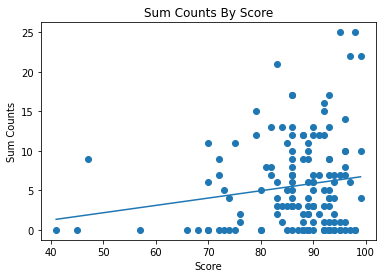

R value for Total Rhetorical Terms is 0.15820899414033246


In [39]:
#Check if amount of all term usage is indicative of grade
#Based on results, there is little relationship between amount of rhetorical terms used and grade...at least between A and B range essays)

#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_keywords_df_full_texts['Portfolio_Score'])
y = np.array(rhetorical_keywords_df_full_texts['Sum_Terms'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.title("Sum Counts By Score")
plt.xlabel("Score")
plt.ylabel("Sum Counts")
plt.show()

print("R value for Total Rhetorical Terms is " + str(r))

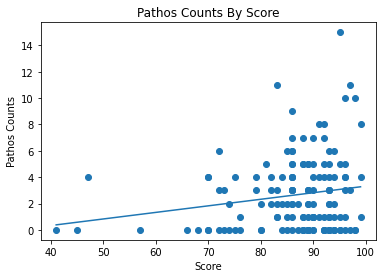

R value for Pathos is 0.17416015822440525


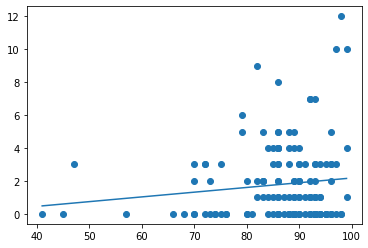

R value for Logos is 0.12072588790923135


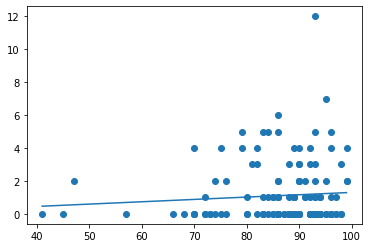

R value for Ethos is 0.07627576594966992


In [40]:
#Check if amount of usages of pathos is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_keywords_df_full_texts['Portfolio_Score'])
y = np.array(rhetorical_keywords_df_full_texts['Pathos_Counts'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.title("Pathos Counts By Score")
plt.xlabel("Score")
plt.ylabel("Pathos Counts")
plt.show()

print("R value for Pathos is " + str(r))


#Check if amount of usages of logos is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_keywords_df_full_texts['Portfolio_Score'])
y = np.array(rhetorical_keywords_df_full_texts['Logos_Counts'])


#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

print("R value for Logos is " + str(r))


#Check if amount of usages of ethos is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_keywords_df_full_texts['Portfolio_Score'])
y = np.array(rhetorical_keywords_df_full_texts['Ethos_Counts'])


#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

print("R value for Ethos is " + str(r))

In [41]:
#Plot # paragraphs in which terms were used vs. essay grade
##In other words, do more successful writers use terms in multiple paragrpahs (indicating more coherence)?

#Count number of paragraphs where terms used and append to new dataframe
new_Series = rhetorical_keywords_paragraphs_df_no_blanks['Score_ID'].value_counts(ascending=True)
df3 = pd.DataFrame(new_Series).reset_index()
df3

df3.rename(columns={"index": "Score_ID", "Score_ID": "Paragraph_Counts"}, errors="raise", inplace=True)
df3[['ID','Score']] = df3.Score_ID.str.split(", ",expand=True)

df3

#Plot paragraph counts per paper
fig = go.Figure(data=[
    go.Bar(name='Paragraph Counts', x=df3["Score_ID"], y=df3["Paragraph_Counts"]),

])
# Change the bar mode
fig.update_layout(title_text='Number of Paragraphs Where Rhetorical Terms Were Used')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'category ascending'})
fig.show()

In [42]:
df3[['Score','ID']] = df3.Score_ID.str.split(", ",expand=True)
df3['Score'] = df3['Score'].map(lambda x: x.lstrip('Score: '))
df3 = df3[['Score','Paragraph_Counts']].copy()
df3 = df3.apply(pd.to_numeric)
df3

,Score,Paragraph_Counts
0,89.0,1
1,84.0,1
2,91.0,1
3,90.0,1
4,93.0,1
...,...,...
102,86.0,8
103,98.0,8
104,99.0,9
105,97.0,9


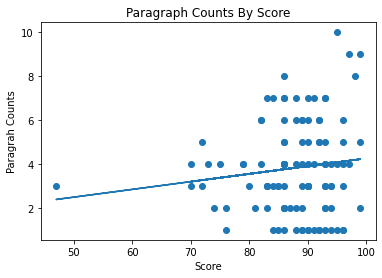

R value for Terms per Paragraph is 0.12665185100384133


In [43]:
#Check if amount of paragraph term usage is indicative of grade
#Based on results (r = .08, there is little relationship between amount of rhetorical terms used and grade...at least between A and B range essays)
from scipy import stats

#Check if amount of usages of all terms per paragraph is indicative of grade
#Create arrays of independent (x) and dependent (y) variables


x = np.array(df3['Score'])
y = np.array(df3['Paragraph_Counts'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.title("Paragraph Counts By Score")
plt.xlabel("Score")
plt.ylabel("Paragrah Counts")
plt.show()

print("R value for Terms per Paragraph is " + str(r))

We'll do the same thing with the synonyms to see if this makes a difference. 

In [128]:
#Get counts of synonym term usages in full texts
full_text_rhetorical_synonym_df = rhetorical_keywords_df_full_texts.copy()
full_text_rhetorical_synonym_df['Pathos_Synonyms'] = full_text_rhetorical_synonym_df['NoStops_Text'].str.count('experience|feel|stories|story|understand|compassion|passion|anecdote|sad|anger|sympathy|sympathetic|empathy|pity|fear*')
full_text_rhetorical_synonym_df['Logos_Synonyms'] = full_text_rhetorical_synonym_df['NoStops_Text'].str.count('logic|reason|reasoning|statistic|fact|data|common sense|evidence')
full_text_rhetorical_synonym_df['Ethos_Synonyms'] = full_text_rhetorical_synonym_df['NoStops_Text'].str.count('credible|credibility|authority|ethic|ethical|reliable')
full_text_rhetorical_synonym_df['Rhetorical_Vocab'] = full_text_rhetorical_synonym_df['NoStops_Text'].str.count('audience|reader|context|rhetorical|element|device|appeal|effective')

#Get summ of each type of term usages
pathos_terms = ['Pathos_Counts', 'Pathos_Synonyms']
full_text_rhetorical_synonym_df['Sum_Pathos_Terms'] = full_text_rhetorical_synonym_df[pathos_terms].sum(axis=1)

logos_terms = ['Logos_Counts', 'Logos_Synonyms']
full_text_rhetorical_synonym_df['Sum_Logos_Terms'] = full_text_rhetorical_synonym_df[logos_terms].sum(axis=1)

ethos_terms = ['Ethos_Counts', 'Ethos_Synonyms']
full_text_rhetorical_synonym_df['Sum_Ethos_Terms'] = full_text_rhetorical_synonym_df[ethos_terms].sum(axis=1)


#Get sum of all term usages
all_terms = ['Sum_Pathos_Terms', 'Sum_Ethos_Terms', 'Sum_Ethos_Terms', 'Rhetorical_Vocab']
full_text_rhetorical_synonym_df['Sum_All_Terms'] = full_text_rhetorical_synonym_df[all_terms].sum(axis=1)
full_text_rhetorical_synonym_df.head()

,ID,Section,Portfolio_Score,Text_Newlines,NoStops_Text,Score_ID,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms,Pathos_Synonyms,Logos_Synonyms,Ethos_Synonyms,Rhetorical_Vocab,Sum_Pathos_Terms,Sum_Logos_Terms,Sum_Ethos_Terms,Sum_All_Terms
13,185594,Section: 039,41.0,...,Vivek Chowdary Kotapati 12/07/2020. Dear Portf...,"Score: 41.0, ID:185594",0,0,0,0,9,6,0,2,9,6,0,11
9,151066,Section: 039,45.0,Temple University\n\n\n\n\n\n\n\n\n\nFinal Wri...,Temple University Final Writing Portfolio Emme...,"Score: 45.0, ID:151066",0,0,0,0,16,37,0,33,16,37,0,49
12,195858,Section: 039,47.0,\n\nSophie Jung ...,"Sophie Jung December 7, 2020 SaraGrace Stefan ...","Score: 47.0, ID:195858",4,2,3,9,29,9,0,4,33,12,2,41
3,192375,Section: 039,57.0,Olivia Davino\nProfessor SaraGrace Stefan\nAna...,Olivia Davino Professor SaraGrace Stefan Analy...,"Score: 57.0, ID:192375",0,0,0,0,18,26,2,6,18,26,2,28
81,199773,Section: 011,66.0,Liam A. Hart\nMegan Kane\nAnalytical Reading a...,Liam A. Hart Megan Kane Analytical Reading Wri...,"Score: 66.0, ID:199773",0,0,0,0,21,8,0,4,21,8,0,25


In [129]:
#Chart number of times each type of term was used in each essay 
#Create bar graph
#https://plotly.com/python/bar-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Sum_Pathos_Terms', x=rhetorical_synonym_df["Score_ID"], y=rhetorical_synonym_df["Sum_Pathos_Terms"]),
    go.Bar(name='Sum_Ethos_Terms', x=rhetorical_synonym_df["Score_ID"], y=rhetorical_synonym_df["Sum_Ethos_Terms"]),
    go.Bar(name='Sum_Logos_Terms', x=rhetorical_synonym_df["Score_ID"], y=rhetorical_synonym_df["Sum_Logos_Terms"]),
    go.Bar(name='Sum_Rhetorical_Vocab', x=rhetorical_synonym_df["Score_ID"], y=rhetorical_synonym_df["Rhetorical_Vocab"])

])


# Change the bar mode
fig.update_layout(title_text='Counts of Each Type of Rhetorical Term in Each Essay')
fig.update_layout(barmode='stack')
fig.show()



In [130]:
#Create new df for numerical values for regression calculations
rhetorical_regression_df = rhetorical_synonym_df[['Score','Sum_Pathos_Terms','Sum_Ethos_Terms',	'Sum_Logos_Terms','Sum_All_Terms', 'Rhetorical_Vocab']].copy()
rhetorical_regression_df = rhetorical_regression_df.apply(pd.to_numeric) 
rhetorical_regression_df

,Score,Sum_Pathos_Terms,Sum_Ethos_Terms,Sum_Logos_Terms,Sum_All_Terms,Rhetorical_Vocab
325,47.0,2,1,1,4,0
349,47.0,3,1,1,6,1
351,47.0,9,0,1,10,1
906,70.0,1,2,1,7,2
908,70.0,3,2,3,13,6
...,...,...,...,...,...,...
21487,99.0,7,2,2,16,5
21489,99.0,6,0,0,11,5
21506,99.0,1,0,1,3,2
21507,99.0,2,4,4,12,2


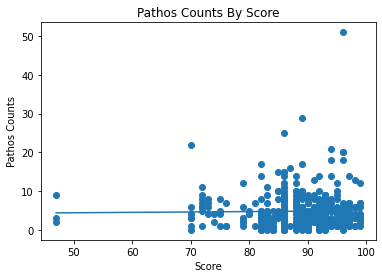

R value for Pathos is 0.016002846752367537


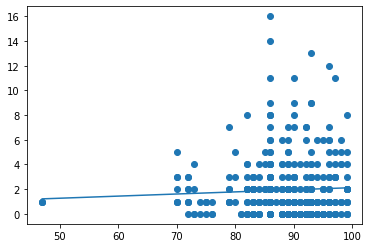

R value for Logos is 0.05178993825433073


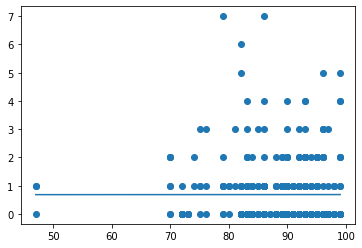

R value for Ethos is 0.00033753025954835357


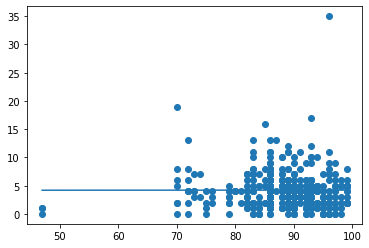

R value for Rhetorical Vocab is 0.0006907843292182815


In [131]:
#Check if amount of usages of pathos is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_regression_df['Score'])
y = np.array(rhetorical_regression_df['Sum_Pathos_Terms'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.title("Pathos Counts By Score")
plt.xlabel("Score")
plt.ylabel("Pathos Counts")
plt.show()

print("R value for Pathos is " + str(r))


#Check if amount of usages of logos is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_regression_df['Score'])
y = np.array(rhetorical_regression_df['Sum_Logos_Terms'])


#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

print("R value for Logos is " + str(r))


#Check if amount of usages of ethos is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_regression_df['Score'])
y = np.array(rhetorical_regression_df['Sum_Ethos_Terms'])


#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

print("R value for Ethos is " + str(r))


#Check if amount of rhetorical term usages is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_regression_df['Score'])
y = np.array(rhetorical_regression_df['Rhetorical_Vocab'])


#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

print("R value for Rhetorical Vocab is " + str(r))



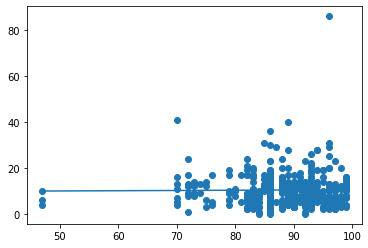

R value for All Terms is 0.010832614426946465


In [48]:
#Check if amount of all term usages is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_regression_df['Score'])
y = np.array(rhetorical_regression_df['Sum_All_Terms'])


#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.show()

print("R value for All Terms is " + str(r))

### Citation Practice Regression Analysis


In [49]:
#Using FULL TEXTS Get any text inside parentheticals and count of parentheticals and append to dataframe
#https://stackoverflow.com/questions/24696715/regex-for-match-parentheses-in-python
parentheticals = r'(?<=\().*?(?=\))'

parenthetical_matches = []
parenthetical_counts = []

citation_df_full_texts = clean_essay_grades_df[['ID', 'Section', 'Portfolio_Score','Text']].copy()
for text in citation_df_full_texts['Text']:
  matches = re.findall(parentheticals, text)
  parenthetical_matches.append(matches)
  parenthetical_counts.append(len(matches))

citation_df_full_texts["Parentheticals"] = parenthetical_matches
citation_df_full_texts['Parenthetical_Counts'] = parenthetical_counts
citation_df_full_texts

,ID,Section,Portfolio_Score,Text,Parentheticals,Parenthetical_Counts
13,185594,Section: 039,41.0,Vivek Chowdary Kotapati 12/07/2020. Dear Port...,[ So the bees could haul its honey back inside],1
9,151066,Section: 039,45.0,Temple University Final Writing Portfolio Emme...,"[p. 46, 44, p.42, 45, 53, 54, 48, 48, 48, 48, ...",41
12,195858,Section: 039,47.0,"Sophie Jung December 7, 2020 SaraGrace Stefan...","[39, “Why Stopping Street Harassment Matters”,...",23
3,192375,Section: 039,57.0,Olivia Davino Professor SaraGrace Stefan Analy...,"[Orso, Orso, Orso, Orso, Orso, Orso, now-mayor...",15
81,199773,Section: 011,66.0,Liam A. Hart Megan Kane Analytical Reading and...,"[Orso, A, Orso, A, either in the moment or lat...",18
...,...,...,...,...,...,...
39,117922,Section: 010,98.0,"Stephanie Robbins SaraGrace Stefan ENG 0802, S...","[637, 639, 7, 5, 6, 7, 11, NIST, 5, 7, 6, 5, 2...",28
33,194101,Section: 010,98.0,"Paul Kushnirsky Professor Stefan English 0802,...","[Knowles and Bellware, Knowles and Bellware, K...",37
23,191777,Section: 010,99.0,Olivia Blake Professor SaraGrace Stefan ENG 08...,[mainly clarifying and expanding upon my comme...,52
28,190146,Section: 010,99.0,Temple University Analytical Reading and Writ...,"[and racist, 305, Baranetsky 312, 305, 305, Ba...",35


In [50]:
#Add ID and score in one column
citation_df_full_texts['Score_ID'] = 'Score: ' + citation_df_full_texts['Portfolio_Score'].astype(str) + ', ID:' + citation_df_full_texts['ID'].astype(str)

In [51]:
#Chart number of times parentheticals were used in each essay 
#Create bar graph
#https://plotly.com/python/bar-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Parenthetical_Tags', x=citation_df_full_texts["Score_ID"], y=citation_df_full_texts["Parenthetical_Counts"])
])
# Change the bar mode
fig.update_layout(title_text='Counts of Parentheticals Used in Each Essay')
fig.update_layout(barmode='stack')
fig.show()

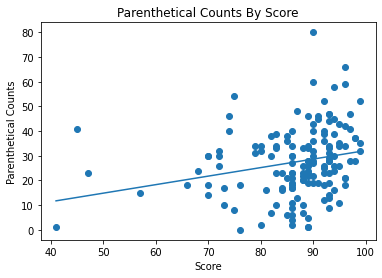

R value for Parentheticals is 0.23960058361891584


In [52]:
#Regression: Parentheticals vs. Grade

#Check if amount of all term usage is indicative of grade
#Based on results (r = .08, there is little relationship between amount of rhetorical terms used and grade...at least between A and B range essays)
from scipy import stats


#Create arrays of independent (x) and dependent (y) variables
x = np.array(citation_df_full_texts['Portfolio_Score'])
y = np.array(citation_df_full_texts['Parenthetical_Counts'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.title("Parenthetical Counts By Score")
plt.xlabel("Score")
plt.ylabel("Parenthetical Counts")
plt.show()

print("R value for Parentheticals is " + str(r))


In [53]:
#Plot # paragraphs in which terms were used vs. essay grade
##In other words, do more successful writers use terms in multiple paragrpahs (indicating more coherence)?

#Count number of paragraphs where terms used and append to new dataframe
new_Series = citation_df['Score_ID'].value_counts(ascending=True)
df3 = pd.DataFrame(new_Series).reset_index()
df3

df3.rename(columns={"index": "Score_ID", "Score_ID": "Paragraph_Counts"}, errors="raise", inplace=True)
df3[['ID','Score']] = df3.Score_ID.str.split(", ",expand=True)

df3

#Plot paragraph counts per paper
fig = go.Figure(data=[
    go.Bar(name='Paragraph Counts', x=df3["Score_ID"], y=df3["Paragraph_Counts"]),

])
# Change the bar mode
fig.update_layout(title_text='Number of Paragraphs Where Citation Terms Were Used')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'category ascending'})
fig.show()

In [54]:
df3[['Score','ID']] = df3.Score_ID.str.split(", ",expand=True)
df3['Score'] = df3['Score'].map(lambda x: x.lstrip('Score: '))
df3 = df3[['Score','Paragraph_Counts']].copy()
df3 = df3.apply(pd.to_numeric)
df3

,Score,Paragraph_Counts
0,89.0,7
1,93.0,16
2,41.0,16
3,81.0,18
4,86.0,19
...,...,...
142,90.0,70
143,86.0,101
144,96.0,111
145,92.0,120


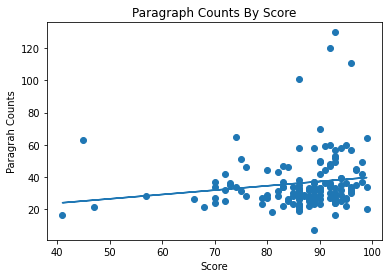

R value for Citation Terms per Paragraph is 0.15072086372650448


In [55]:
#Check if amount of paragraph term usage is indicative of grade
#Based on results (r = .08, there is little relationship between amount of rhetorical terms used and grade...at least between A and B range essays)
from scipy import stats

#Check if amount of usages of all terms per paragraph is indicative of grade
#Create arrays of independent (x) and dependent (y) variables


x = np.array(df3['Score'])
y = np.array(df3['Paragraph_Counts'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.title("Paragraph Counts By Score")
plt.xlabel("Score")
plt.ylabel("Paragrah Counts")
plt.show()

print("R value for Citation Terms per Paragraph is " + str(r))

In [129]:
##Let's do the same using DocuScope citation data
#Upload csv with LAT data
uploaded_LATS = files.upload()

Saving DIMENSION_C_deidentified_texts_citation_clusters_dimensions.csv to DIMENSION_C_deidentified_texts_citation_clusters_dimensions.csv


In [130]:
lats_df = pd.read_csv('DIMENSION_C_deidentified_texts_citation_clusters_dimensions.csv')
lats_df

,Filename,CitationAuthority,CitationControversy,CitationGeneric,CitationHedged,CitationNegative,CitationNeutral,CitationSpeakerLookMood,UncertainCitation,Citation
0,117922.txt,19,9,34,0,0,31,0,0,93
1,142981.txt,7,7,34,0,0,17,0,0,65
2,151066.txt,15,24,46,0,0,13,0,0,98
3,153053.txt,2,0,0,0,0,1,0,0,3
4,153690.txt,14,5,21,1,0,38,1,0,80
...,...,...,...,...,...,...,...,...,...,...
142,233133.txt,11,2,25,0,0,27,0,0,65
143,233386.txt,8,6,15,1,0,27,0,0,57
144,233407.txt,5,6,21,0,0,19,0,0,51
145,237430.txt,21,0,9,0,0,19,0,0,49


In [131]:
#Make ID document to merge docuscope lats with
ids = clean_essay_grades_df[['ID', 'Portfolio_Score']].copy()
ids

#Rename filename column to id and merge target and LAT tables based on ID
lats_df.rename(columns={"Filename": "ID"}, inplace=True)
lats_df['ID'] = lats_df['ID'].map(lambda x: x.rstrip('.txt'))
lats_df['ID'] = lats_df['ID'].astype('float')
merged_lat_df = pd.merge(ids, lats_df, on='ID')

#Add ID and score in one column
merged_lat_df['Score_ID'] = 'Score: ' + merged_lat_df['Portfolio_Score'].astype(str) + ', ID:' + merged_lat_df['ID'].astype(str)
merged_lat_df

,ID,Portfolio_Score,CitationAuthority,CitationControversy,CitationGeneric,CitationHedged,CitationNegative,CitationNeutral,CitationSpeakerLookMood,UncertainCitation,Citation,Score_ID
0,185594,41.0,0,1,7,0,0,23,0,0,31,"Score: 41.0, ID:185594"
1,151066,45.0,15,24,46,0,0,13,0,0,98,"Score: 45.0, ID:151066"
2,195858,47.0,1,1,19,0,0,15,0,0,36,"Score: 47.0, ID:195858"
3,192375,57.0,11,4,19,0,0,11,0,0,45,"Score: 57.0, ID:192375"
4,199773,66.0,7,0,27,0,0,11,0,0,45,"Score: 66.0, ID:199773"
...,...,...,...,...,...,...,...,...,...,...,...,...
142,117922,98.0,19,9,34,0,0,31,0,0,93,"Score: 98.0, ID:117922"
143,156676,98.0,10,8,9,0,0,13,0,0,40,"Score: 98.0, ID:156676"
144,190309,99.0,17,6,23,0,1,22,1,0,70,"Score: 99.0, ID:190309"
145,190146,99.0,23,2,36,2,0,26,0,0,89,"Score: 99.0, ID:190146"


In [132]:
#Chart number of times all terms were used in each essay 
#Create bar graph
#https://plotly.com/python/bar-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Citations_Tags', x=merged_lat_df["Score_ID"], y=merged_lat_df["Citation"])
])
# Change the bar mode
fig.update_layout(title_text='Counts of All Citation Cluster Terms Used in Each Essay')
fig.update_layout(barmode='stack')
fig.show()

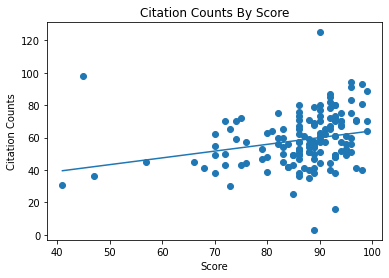

R value for Total Citation Terms is 0.24817423178493675


In [133]:
#Regression: Citation vs. Grade

#Check if amount of all term usage is indicative of grade
#Based on results (r = .08, there is little relationship between amount of rhetorical terms used and grade...at least between A and B range essays)
from scipy import stats


#Create arrays of independent (x) and dependent (y) variables
x = np.array(merged_lat_df['Portfolio_Score'])
y = np.array(merged_lat_df['Citation'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

#Create function to return new equation
def myfunc(x):
  return slope * x + intercept

mymodel = list(map(myfunc, x))

plt.scatter(x, y)
plt.plot(x, mymodel)
plt.title("Citation Counts By Score")
plt.xlabel("Score")
plt.ylabel("Citation Counts")
plt.show()

print("R value for Total Citation Terms is " + str(r))


In [134]:
#Chart number of times each citation dimension was used in each essay 
#Create bar graph
#https://plotly.com/python/bar-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='CitationAuthority', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationAuthority"]),
    go.Bar(name='CitationControversy', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationControversy"]),
    go.Bar(name='CitationGeneric', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationGeneric"]),
    go.Bar(name='CitationHedged', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationHedged"]),
    go.Bar(name='CitationNegative', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationNegative"]),
    go.Bar(name='CitationNeutral', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationNeutral"]),
    go.Bar(name='CitationSpeakerLookMood', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationSpeakerLookMood"]),
    go.Bar(name='UncertainCitation', x=merged_lat_df["Score_ID"], y=merged_lat_df["UncertainCitation"]),

])


# Change the bar mode
fig.update_layout(title_text='Counts of Each Rhetorical Term in Each Essay')
fig.update_layout(barmode='stack')
fig.show()

### Principal Component Analysis for Rhetorical & Citation Terms

In [135]:
#Drop unneeded columns from each dataframe to merge
#DataFrame with all rhetorical term counts
rhetorical_keywords_df_full_texts_merge = rhetorical_keywords_df_full_texts.drop(['Score_ID', 'Text_Newlines', 'NoStops_Text', "Section"], axis=1)

#DataFrame with parenthetical citations
citation_df_full_texts_merge = citation_df_full_texts.drop(['Score_ID', 'Text', 'Parentheticals', 'Portfolio_Score'], axis=1)

#Dataframe with DocuScope citation counts
lats_df

#Merge DataFrames together
dfs = [rhetorical_keywords_df_full_texts_merge, citation_df_full_texts_merge, lats_df]

import functools as ft
df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='ID'), dfs)

df_final

,ID,Portfolio_Score,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms,Section,Parenthetical_Counts,CitationAuthority,CitationControversy,CitationGeneric,CitationHedged,CitationNegative,CitationNeutral,CitationSpeakerLookMood,UncertainCitation,Citation
0,185594,41.0,0,0,0,0,Section: 039,1,0,1,7,0,0,23,0,0,31
1,151066,45.0,0,0,0,0,Section: 039,41,15,24,46,0,0,13,0,0,98
2,195858,47.0,4,2,3,9,Section: 039,23,1,1,19,0,0,15,0,0,36
3,192375,57.0,0,0,0,0,Section: 039,15,11,4,19,0,0,11,0,0,45
4,199773,66.0,0,0,0,0,Section: 011,18,7,0,27,0,0,11,0,0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,117922,98.0,0,0,0,0,Section: 010,28,19,9,34,0,0,31,0,0,93
143,156676,98.0,0,0,0,0,Section: 010,37,10,8,9,0,0,13,0,0,40
144,190309,99.0,4,2,4,10,Section: 010,32,17,6,23,0,1,22,1,0,70
145,190146,99.0,8,4,10,22,Section: 010,35,23,2,36,2,0,26,0,0,89


In [145]:
#Get identifying data (scores and filenames)
targets = df_final[['ID', 'Portfolio_Score']]

#Sort by grade
targets.sort_values(by=['Portfolio_Score'], inplace=True)

#Create new column to label essays based on grade range
def calc_new_col(row):
  if row['Portfolio_Score'] <= 75:
     return 'Low-Scoring'
  if row['Portfolio_Score'] >= 95:
     return 'High-Scoring'
  else:
    return 'Mid-Scoring'

targets["Range"] = targets.apply(calc_new_col, axis=1)

#Drop unnecessary columns
targets = targets.drop(["Portfolio_Score"], axis=1)

targets.head()

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-145-8020dc8fd0ac>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ID,Range
0,185594,Low-Scoring
1,151066,Low-Scoring
2,195858,Low-Scoring
3,192375,Low-Scoring
4,199773,Low-Scoring


In [146]:
#Merge target and df_final based ono filename
PCA_df = pd.merge(targets, df_final, on='ID')

PCA_df

#Drop unnecessary columns
PCA_df = PCA_df.drop(["ID","Section", "Portfolio_Score"], axis=1)

# shift column 'Range' to first position
first_column = PCA_df.pop('Range')
  
# insert column using insert(position,column_name,
# first_column) function
PCA_df.insert(0, 'Range', first_column)
PCA_df.head()


,Range,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms,Parenthetical_Counts,CitationAuthority,CitationControversy,CitationGeneric,CitationHedged,CitationNegative,CitationNeutral,CitationSpeakerLookMood,UncertainCitation,Citation
0,Low-Scoring,0,0,0,0,1,0,1,7,0,0,23,0,0,31
1,Low-Scoring,0,0,0,0,41,15,24,46,0,0,13,0,0,98
2,Low-Scoring,4,2,3,9,23,1,1,19,0,0,15,0,0,36
3,Low-Scoring,0,0,0,0,15,11,4,19,0,0,11,0,0,45
4,Low-Scoring,0,0,0,0,18,7,0,27,0,0,11,0,0,45


In [147]:
#Separate the features from the target
# Separating out the target
y = PCA_df.loc[:,['Range']].values

# Separating out the features
PCA_df_2 = PCA_df.drop(["Range"], axis=1)
x = PCA_df_2.values

# Standardizing the features
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)

In [148]:
#Project to 2D via principal component analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf

,principal component 1,principal component 2
0,-3.535259,1.552107
1,1.092216,-3.786756
2,-0.572457,2.410990
3,-2.172430,0.317774
4,-2.146382,0.294742
...,...,...
142,0.400299,-3.290282
143,-2.161794,0.173569
144,5.954989,0.493820
145,1.890037,-0.896411


In [149]:
#Concatenate with the range values
finalDf = pd.concat([principalDf, PCA_df[['Range']]], axis = 1)

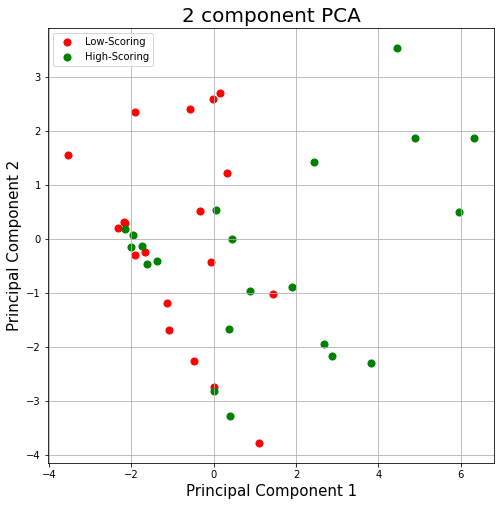

In [151]:
#Plot PCA results
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Low-Scoring','High-Scoring']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Range'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [152]:
#Get the explained variance ratio
pca.explained_variance_ratio_

array([0.24952447, 0.2065598 ])

### Principal Component Analysis for DocuScope Clusters

In [ ]:
#Upload rhetorical csv with DocuScope data
all_clusters = files.upload()

Saving DIMENSION_N_deidentified_texts.csv to DIMENSION_N_deidentified_texts.csv


In [ ]:
#Put citation clusters in df
all_clusters_df = pd.read_csv('DIMENSION_N_deidentified_texts.csv')
all_clusters_df

,Filename,Tokens,AcademicAnatomy,AcademicApproach,AcademicArt,AcademicArtArchitecture,AcademicArtists,AcademicArtLanguageDrama,AcademicArtLanguageLiterature,AcademicBibliometrics,...,UpdatesNegativeDimensionGeneral,UpdatesNegativeNewsBad,UpdatesNegativeNewsLatest,UpdatesNegativeNotice,UpdatesNegativeStraightshooterLayOnTheLine,UpdatesPositiveDimensionGeneral,UpdatesPositiveNewsGood,UpdatesPositiveNewsLatest,UpdatesPositiveNotice,Group
0,117922.txt,6688,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.010167,0.000748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,142981.txt,6846,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.006719,0.000438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,151066.txt,6685,0.000000,0.000150,0.000000,0.0,0.0,0.0,0.007180,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,153053.txt,788,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.002538,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,153690.txt,8178,0.000367,0.000000,0.000000,0.0,0.0,0.0,0.010027,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,233133.txt,8313,0.000241,0.000241,0.000120,0.0,0.0,0.0,0.005894,0.000120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
143,233386.txt,5597,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.006253,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
144,233407.txt,4805,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.005203,0.000208,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
145,237430.txt,7178,0.000000,0.000000,0.000279,0.0,0.0,0.0,0.007662,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [ ]:
#Rename filename column to id and merge target and LAT tables based on ID
all_clusters_df.rename(columns={"Filename": "ID"}, inplace=True)
all_clusters_df['ID'] = all_clusters_df['ID'].map(lambda x: x.rstrip('.txt'))
all_clusters_df['ID'] = all_clusters_df['ID'].astype('float')

#Make ID document to merge docuscope lats with
ids = clean_essay_grades_df[['ID', 'Portfolio_Score']].copy()

all_clusters_df = pd.merge(ids, all_clusters_df, on='ID')

In [ ]:
#Get identifying data (scores and filenames)
targets = all_clusters_df[['ID', 'Portfolio_Score']]

#Sort by grade
targets.sort_values(by=['Portfolio_Score'], inplace=True)

#Create new column to label essays based on grade range
def calc_new_col(row):
  if row['Portfolio_Score'] <= 75:
     return 'Low-Scoring'
  if row['Portfolio_Score'] >= 90:
     return 'High-Scoring'
  else:
    return 'Mid-Scoring'

targets["Range"] = targets.apply(calc_new_col, axis=1)

#Drop unnecessary columns
targets = targets.drop(["Portfolio_Score"], axis=1)

targets.head()

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-247-227296d68d54>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ID,Range
0,185594,Low-Scoring
1,151066,Low-Scoring
2,195858,Low-Scoring
3,192375,Low-Scoring
4,199773,Low-Scoring


In [ ]:
#Merge target and df_final based ono filename
PCA_df = pd.merge(targets, all_clusters_df, on='ID')

PCA_df

#Drop unnecessary columns
PCA_df = PCA_df.drop(["ID", "Portfolio_Score", "Group", "Tokens"], axis=1)

# shift column 'Range' to first position
first_column = PCA_df.pop('Range')
  
# insert column using insert(position,column_name,
# first_column) function
PCA_df.insert(0, 'Range', first_column)

PCA_df.head()


,Range,AcademicAnatomy,AcademicApproach,AcademicArt,AcademicArtArchitecture,AcademicArtists,AcademicArtLanguageDrama,AcademicArtLanguageLiterature,AcademicBibliometrics,AcademicCognates,...,UpdatesWitnesses,UpdatesNegativeDimensionGeneral,UpdatesNegativeNewsBad,UpdatesNegativeNewsLatest,UpdatesNegativeNotice,UpdatesNegativeStraightshooterLayOnTheLine,UpdatesPositiveDimensionGeneral,UpdatesPositiveNewsGood,UpdatesPositiveNewsLatest,UpdatesPositiveNotice
0,Low-Scoring,0.0,0.000000,0.0,0.0,0.0,0.0,0.003493,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Low-Scoring,0.0,0.000150,0.0,0.0,0.0,0.0,0.007180,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Low-Scoring,0.0,0.000000,0.0,0.0,0.0,0.0,0.003143,0.000484,0.000242,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Low-Scoring,0.0,0.000000,0.0,0.0,0.0,0.0,0.007165,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Low-Scoring,0.0,0.000161,0.0,0.0,0.0,0.0,0.002410,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Separate the features from the target
# Separating out the target
y = PCA_df.loc[:,['Range']].values

# Separating out the features
PCA_df_2 = PCA_df.drop(["Range"], axis=1)
x = PCA_df_2.values

# Standardizing the features
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)

In [ ]:
#Project to 2D via principal component analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf

,principal component 1,principal component 2
0,5.061155,2.496820
1,-5.168123,-0.658008
2,5.719771,0.452024
3,1.439026,-4.319648
4,11.832765,1.333341
...,...,...
142,-0.756019,-4.158602
143,-6.226230,-1.588013
144,-4.074780,-0.999961
145,-10.267814,8.878539


In [ ]:
#Concatenate with the range values
finalDf = pd.concat([principalDf, PCA_df[['Range']]], axis = 1)

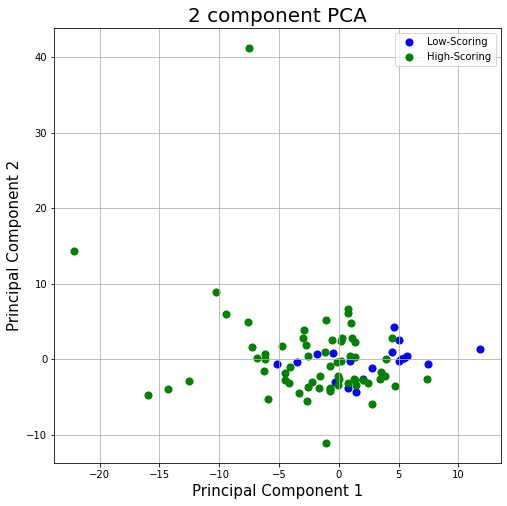

In [ ]:
#Plot PCA results
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Low-Scoring','High-Scoring']
colors = ['b', 'g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Range'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
#Get the explained variance ratio
pca.explained_variance_ratio_

array([0.01521663, 0.01418537])

##5. Analyze Language Pattern Differences Between Outcomes

This section uses Word2Vec and Principal Component Analysis to determine whether students use distinct language patterns in paragraphs where citation practices are used vs. where rhetorical language is used. The language patterns measured are identified by DocuScope, a computational rhetorical analysis platform. 

### Word2Vec

In [91]:
#Create new dataframe for word2vec
word2vec_essays = essays_grades_master[['ID', 'Portfolio_Score', 'NoStops_Text']].copy()
word2vec_essays

#Split dataframe into three groups based on grades
low = 80
high = 90
c_range = word2vec_essays[word2vec_essays['Portfolio_Score'] <= low]
b_range = word2vec_essays[word2vec_essays['Portfolio_Score'] > low]
b_range = b_range[word2vec_essays['Portfolio_Score'] <= high]
a_range = word2vec_essays[word2vec_essays['Portfolio_Score'] > high]

<ipython-input-91-0d4fa585be12>:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



#### Word2Vec on High-Scoring Essays

In [92]:
#Define spaCy function to lemmatize, remove stopwords and non-alphanumeric characters
nlp = spacy.load('en_core_web_sm')

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [93]:
#Remove characters
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in a_range['NoStops_Text'])
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

#Put results in a new dataframe
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(54, 1)

In [94]:
#Use bigrams to detect common phrases
from gensim.models.phrases import Phrases, Phraser

#Take list of list of words as input
sent = [row.split() for row in df_clean['clean']]

#Creates relevant list of phrases from all sentences
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)

#Transform the corpus based on the bigrams detected:
sentences = bigram[sent]

In [95]:
#Count word frequency
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

12335

In [96]:
#Get most frequent words
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['s',
 'social_medium',
 'people',
 'surveillance',
 'article',
 'use',
 'issue',
 'write',
 'woman',
 'gay']

In [97]:
#Import word2vec
import multiprocessing

from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [98]:
#Build word2vecmodel (check how to set parameters in tutorial)
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [99]:
#Build vocab table--digest all words, filter out unique words, do counts on them
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.03 mins


In [100]:
#Set parameters to train the model
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.39 mins


In [101]:
#Now that the model has been trained, make it more memory efficient
w2v_model.init_sims(replace=True)

In [102]:
#Find most similar words to pathos in a-range essays
w2v_model.wv.most_similar(positive=["pathos"])

[('ethos', 0.9983853697776794),
 ('logo', 0.9965421557426453),
 ('appeal', 0.9944419860839844),
 ('use_pathos', 0.9944366216659546),
 ('reader', 0.9892926216125488),
 ('tone', 0.9883193969726562),
 ('element', 0.9835968017578125),
 ('persuade', 0.9835231900215149),
 ('strengthen', 0.9834058284759521),
 ('invoke', 0.9824854135513306)]

In [103]:
#Find most similar words to key terms in corpus
w2v_model.wv.most_similar(positive=["ethos"])

[('pathos', 0.9983853101730347),
 ('logo', 0.9937731623649597),
 ('appeal', 0.9915875196456909),
 ('use_pathos', 0.9907843470573425),
 ('rhetorical_device', 0.9890320301055908),
 ('strengthen', 0.9886208772659302),
 ('element', 0.9880535006523132),
 ('reader', 0.9878939390182495),
 ('persuade', 0.9869668483734131),
 ('tone', 0.985396146774292)]

In [104]:
#Check similarity between words
w2v_model.wv.similarity("pathos", 'ethos')

0.99838525

In [105]:
#Analogy difference
w2v_model.wv.most_similar(positive=["pathos", "ethos"], negative=["emotion"], topn=3)

[('rhetorical', 0.9864258766174316),
 ('rhetorical_device', 0.9810103178024292),
 ('strengthen', 0.978786051273346)]

#### Word2Vec on C Range Essays

In [106]:
#Remove characters
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in c_range['NoStops_Text'])
txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

#Put results in a new dataframe
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(26, 1)

In [107]:
#Use bigrams to detect common phrases
from gensim.models.phrases import Phrases, Phraser

#Take list of list of words as input
sent = [row.split() for row in df_clean['clean']]

#Creates relevant list of phrases from all sentences
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)

#Transform the corpus based on the bigrams detected:
sentences = bigram[sent]

In [108]:
#Count word frequency
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

6972

In [109]:
#Get most frequent words
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['people',
 'social_medium',
 'surveillance',
 's',
 'article',
 'information',
 'woman',
 'use',
 'like',
 'way']

In [110]:
#Import word2vec
import multiprocessing

from gensim.models import Word2Vec

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [111]:
#Build word2vecmodel (check how to set parameters in tutorial)
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [112]:
#Build vocab table--digest all words, filter out unique words, do counts on them
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.01 mins


In [113]:
#Set parameters to train the model
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.14 mins


In [114]:
#Now that the model has been trained, make it more memory efficient
w2v_model.init_sims(replace=True)

In [115]:
#Find most similar words to key terms in corpus of c-range essays
w2v_model.wv.most_similar(positive=["pathos"])

[('audience', 0.9998705387115479),
 ('story', 0.9998486638069153),
 ('appeal', 0.9998477101325989),
 ('logo', 0.9998446702957153),
 ('emotion', 0.9997786283493042),
 ('ethos', 0.9997544288635254),
 ('argument', 0.9997525811195374),
 ('interview', 0.9997438788414001),
 ('include', 0.999736487865448),
 ('walk', 0.9997357130050659)]

In [116]:
#Find most similar words to key terms in corpus
w2v_model.wv.most_similar(positive=["ethos"])

[('logo', 0.9998781681060791),
 ('emotion', 0.999876856803894),
 ('argument', 0.999873697757721),
 ('point', 0.9998252391815186),
 ('ross_gay', 0.9998244047164917),
 ('try', 0.99981689453125),
 ('able', 0.999814510345459),
 ('include', 0.9998124837875366),
 ('talk', 0.9998109340667725),
 ('understand', 0.9998079538345337)]

In [117]:
#Check similarity between words
w2v_model.wv.similarity("pathos", 'ethos')

0.99975437

In [118]:
#Analogy difference
w2v_model.wv.most_similar(positive=["pathos", "ethos"], negative=["emotion"], topn=3)

[('logo', 0.9997577667236328),
 ('appeal', 0.9997018575668335),
 ('audience', 0.9996896982192993)]

### PCA for Rhetorical and Citation Terms

In [144]:
#Upload rhetorical csv with DocuScope data
rhet_clusters = files.upload()

Saving CLUSTER_N_deidentified_texts.csv to CLUSTER_N_deidentified_texts.csv


In [150]:
#Put rhetorical clusters in df
rhet_clusters_df = pd.read_csv('CLUSTER_N_deidentified_texts.csv')
rhet_clusters_df.head()

,Filename,Tokens,AcademicTerms,AcademicWritingMoves,CharacterCognitiveAgency,CharacterCognitiveStates,CharacterCognitiveStatesNegative,CharacterCognitiveStatesPositive,CharacterDisclosive,CharacterDisclosiveNegative,...,ResponsiblityNegative,ResponsiblityPositive,Strategic,StrategicNegative,StrategicPositive,Uncertainty,Updates,UpdatesNegative,UpdatesPositive,Group
0,117922.txt,6688,0.055323,0.006429,0.004037,0.003439,0.001346,0.000449,0.002243,0.0,...,0.000000,0.000000,0.010467,0.001495,0.001047,0.000299,0.001794,0.0,0.0,NaN
1,142981.txt,6846,0.045136,0.003652,0.005259,0.002775,0.000730,0.000438,0.001461,0.0,...,0.000292,0.000000,0.014315,0.002921,0.000730,0.000146,0.004528,0.0,0.0,NaN
2,151066.txt,6685,0.057143,0.002543,0.002543,0.002693,0.000449,0.000150,0.000598,0.0,...,0.000299,0.000000,0.017352,0.002393,0.000150,0.000598,0.007479,0.0,0.0,NaN
3,153053.txt,788,0.032995,0.001269,0.007614,0.008883,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.008883,0.000000,0.001269,0.000000,0.003807,0.0,0.0,NaN
4,153690.txt,8178,0.040597,0.002568,0.005503,0.002812,0.000245,0.000122,0.002323,0.0,...,0.000122,0.000122,0.011861,0.008437,0.000122,0.000122,0.004769,0.0,0.0,NaN


In [151]:
#Label all as rhetorical analysis paragraphs
def calc_new_col(row):
  if row['Filename'] != 0:
     return 'Rhetorical_Analysis'

rhet_clusters_df["Range"] = rhet_clusters_df.apply(calc_new_col, axis=1)

rhet_clusters_df

,Filename,Tokens,AcademicTerms,AcademicWritingMoves,CharacterCognitiveAgency,CharacterCognitiveStates,CharacterCognitiveStatesNegative,CharacterCognitiveStatesPositive,CharacterDisclosive,CharacterDisclosiveNegative,...,ResponsiblityPositive,Strategic,StrategicNegative,StrategicPositive,Uncertainty,Updates,UpdatesNegative,UpdatesPositive,Group,Range
0,117922.txt,6688,0.055323,0.006429,0.004037,0.003439,0.001346,0.000449,0.002243,0.000000,...,0.000000,0.010467,0.001495,0.001047,0.000299,0.001794,0.0,0.0,NaN,Rhetorical_Analysis
1,142981.txt,6846,0.045136,0.003652,0.005259,0.002775,0.000730,0.000438,0.001461,0.000000,...,0.000000,0.014315,0.002921,0.000730,0.000146,0.004528,0.0,0.0,NaN,Rhetorical_Analysis
2,151066.txt,6685,0.057143,0.002543,0.002543,0.002693,0.000449,0.000150,0.000598,0.000000,...,0.000000,0.017352,0.002393,0.000150,0.000598,0.007479,0.0,0.0,NaN,Rhetorical_Analysis
3,153053.txt,788,0.032995,0.001269,0.007614,0.008883,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.008883,0.000000,0.001269,0.000000,0.003807,0.0,0.0,NaN,Rhetorical_Analysis
4,153690.txt,8178,0.040597,0.002568,0.005503,0.002812,0.000245,0.000122,0.002323,0.000000,...,0.000122,0.011861,0.008437,0.000122,0.000122,0.004769,0.0,0.0,NaN,Rhetorical_Analysis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,233133.txt,8313,0.050042,0.003368,0.005052,0.002767,0.000361,0.001564,0.002045,0.000000,...,0.000000,0.010826,0.005052,0.000962,0.000120,0.003849,0.0,0.0,NaN,Rhetorical_Analysis
143,233386.txt,5597,0.048061,0.004824,0.004824,0.001429,0.001072,0.001251,0.000893,0.000000,...,0.000000,0.008219,0.008576,0.000536,0.000179,0.003037,0.0,0.0,NaN,Rhetorical_Analysis
144,233407.txt,4805,0.049116,0.006452,0.007076,0.003746,0.001457,0.000208,0.001873,0.000000,...,0.000000,0.015609,0.004370,0.001665,0.000832,0.003122,0.0,0.0,NaN,Rhetorical_Analysis
145,237430.txt,7178,0.030789,0.002508,0.004876,0.002926,0.000557,0.000000,0.001950,0.000139,...,0.000000,0.015464,0.007523,0.000418,0.000418,0.003622,0.0,0.0,NaN,Rhetorical_Analysis


In [ ]:
#Upload rhetorical csv with DocuScope data
citation_clusters = files.upload()

In [ ]:
#Put citation clusters in df
citation_clusters_df = pd.read_csv('CLUSTER_C_citation_paragraphs.csv')
citation_clusters_df

In [ ]:
#Label all as citation paragraphs
def calc_new_col(row):
  if row['Filename'] != 0:
     return 'Citation_Analysis'

citation_clusters_df["Range"] = citation_clusters_df.apply(calc_new_col, axis=1)

citation_clusters_df

In [ ]:
#Concat DocuScope dataframes for two types of paragraph and label whether they are citation or rhetorical analysis (some may be duplicates)
merged_df = pd.concat((rhet_clusters_df,citation_clusters_df)).sort_index(kind='mergesort').reset_index(drop=True)

#Drop unnecessary columns
#merged_df = merged_df.drop(['Tokens', 'Filename', 'Group'], axis=1)

# shift column 'Range' to first position
first_column = merged_df.pop('Range')
  
# insert column using insert(position,column_name,
# first_column) function
merged_df.insert(0, 'Range', first_column)

merged_df

In [153]:
merged_df = rhet_clusters_df

In [ ]:
b = merged_df['Filename'].ne(merged_df['Filename'].shift()).cumsum()
merged_df.groupby(b, as_index=False).agg({'Filename': 'first', 'Range': ', '.join})

In [ ]:
merged_df = merged_df.groupby(['Range'].apply(lambda x: ', '.join(set(x)) ).reset_index()
merged_df

In [ ]:
#Separate the features from the target
# Separating out the target
y = merged_df.loc[:,['Range']].values

# Separating out the features
PCA_df_2 = merged_df.drop(["Range"], axis=1)
x = PCA_df_2.values

# Standardizing the features
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(x)

In [ ]:
#Project to 2D via principal component analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf

In [ ]:
#Concatenate with the range values
finalDf = pd.concat([principalDf, merged_df[['Range']]], axis = 1)

In [ ]:
#Plot PCA results
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Rhetorical_Analysis',  'Citation_Analysis']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Range'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:
#Get the explained variance ratio
pca.explained_variance_ratio_